In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os


In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [3]:
from masa_utils import PsuedoLog
from masa_utils import Debye_decmp_res_f as DDR_f_np
from masa_utils import Debye_decmp_con_f as DDC_f_np
from masa_utils import Pelton_res_f as Pelton_res_f_np
from masa_utils import Cole_Cole_con_f as ColeCole_con_f_np
from masa_utils import InducedPolarizationSimulation as IP_sim_np
from masa_utils import Optimization as Optimization_np
from masa_utils_pytorch import Pelton 
from masa_utils_pytorch import ColeCole
from masa_utils_pytorch import Debye_Sum_Ser_f, Debye_Sum_Par_f
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Optimization

# SIP-Jacobian for Pelton Model 

In [4]:
res0= 0.2
con8 = 10.0
eta= 0.5
expc= 0.5
tau= 0.01 #0.001
taupel = tau
taucc = tau*(1-eta)**(1/expc)
print(f"time constant, Pelton:{taupel:.3e}, Cole-Cole: {taucc:.3e}")
parm_true = torch.tensor([np.log(res0), eta, np.log(taupel), expc], dtype=torch.float32, requires_grad=False)
model_obs = np.r_[np.log(res0), eta, np.log(taupel), expc]

time constant, Pelton:1.000e-02, Cole-Cole: 2.500e-03


In [5]:
nfreq = 71
freqstrt_log = -2
freqend_log = 5
freq = np.logspace(-2, 5, nfreq)
freq_plot = freq
# print(freq.shape)
# print(freq)

In [6]:
# simulate for Pytroch
IP_model = Pelton(freq=freq)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
dpred_torch = sim.dpred(parm_true)
J_torch = sim.J(parm_true)

In [7]:
dpred_torch_real = dpred_torch[:nfreq].detach().numpy()
dpred_torch_imag = dpred_torch[nfreq:].detach().numpy()
J_torch_real = J_torch[:nfreq, :].detach().numpy()
J_torch_imag = J_torch[nfreq:, :].detach().numpy()
dpred_pel_real = dpred_torch_real
dpred_pel_imag = dpred_torch_imag
J_pel_real = J_torch_real
J_pel_imag = J_torch_imag

In [8]:
# simulate for numpy which has analytic derivative
IP_model_np = Pelton_res_f_np(freq=freq)
sim_np = IP_sim_np(ip_model=IP_model_np, mode="sip")
dpred_np = sim_np.dpred(model_obs)
J_np = sim_np.J(model_obs)

In [9]:
dpred_np_real = dpred_np[:nfreq]
dpred_np_imag = dpred_np[nfreq:]
J_np_real = J_np[:nfreq, :]
J_np_imag = J_np[nfreq:, :]


In [10]:
PL_pelton = PsuedoLog(
            logmin=1e-7,
            linScale=0.2,
            logminx=10.**np.floor(np.log10(freq_plot[freq_plot>eps].min())),
            linScalex=0.2)

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


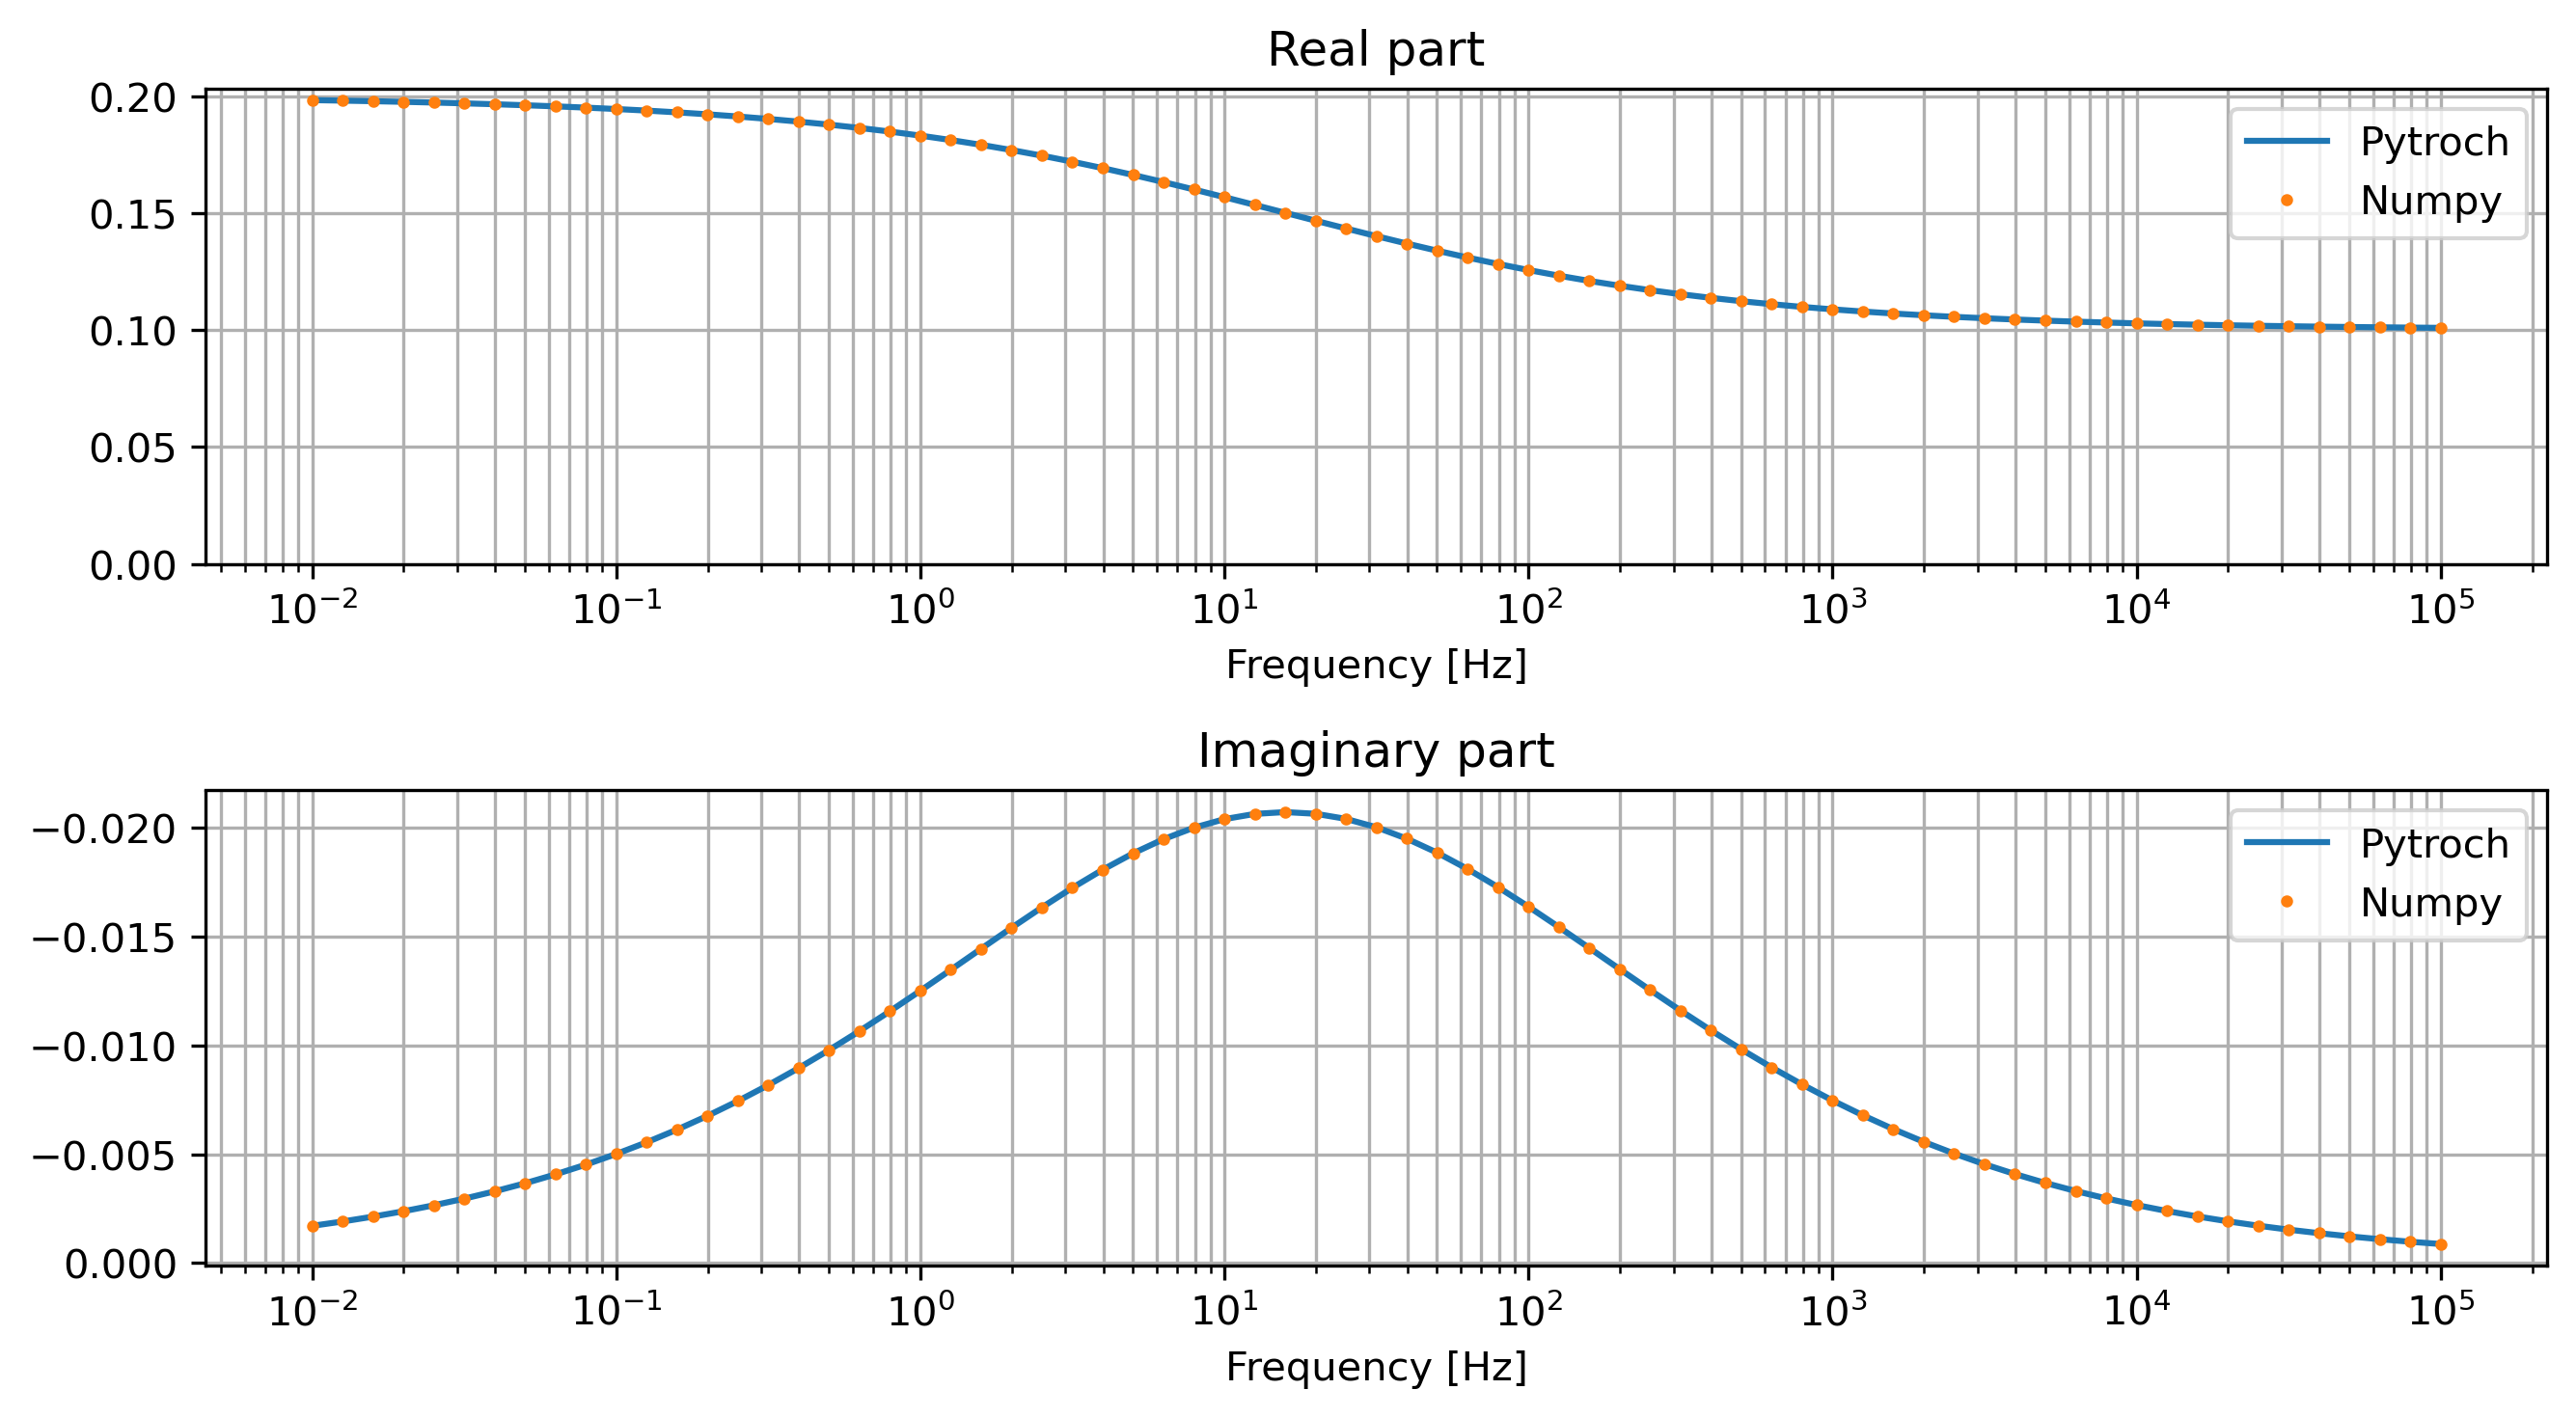

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(9, 5),dpi=300)

ax[0].semilogx(freq, dpred_torch_real,color = "C0",label="Pytroch")
ax[0].semilogx(freq, dpred_np_real, color = "C1",
              linestyle="",markersize=4.0, marker=".",label="Numpy")
ax[0].set_ylim(bottom=0)

ax[1].semilogx (freq, dpred_torch_imag, color = "C0",label="Pytroch")
ax[1].semilogx(freq, dpred_np_imag,  color = "C1",               
              linestyle="",markersize=4.0, marker=".",label="Numpy")
ax[1].invert_yaxis()

# ax[2].plot(dpred_torch_real, -dpred_torch_imag, color="C0", label="Pytroch")
# ax[2].plot(dpred_np_real, -dpred_np_imag, color="C1",
#               linestyle="",markersize=4.0, marker=".",label="Numpy")
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_title("Real part")
ax[1].set_title("Imaginary part")
# ax[2].set_title("Cole-Cole plot")
# ax[2].set_xlabel("Real")
# ax[2].set_ylabel("-Imaginary")
plt.tight_layout()
plt.savefig("30_AuoDiffValid_Pelton_sip.jpg", dpi=300)

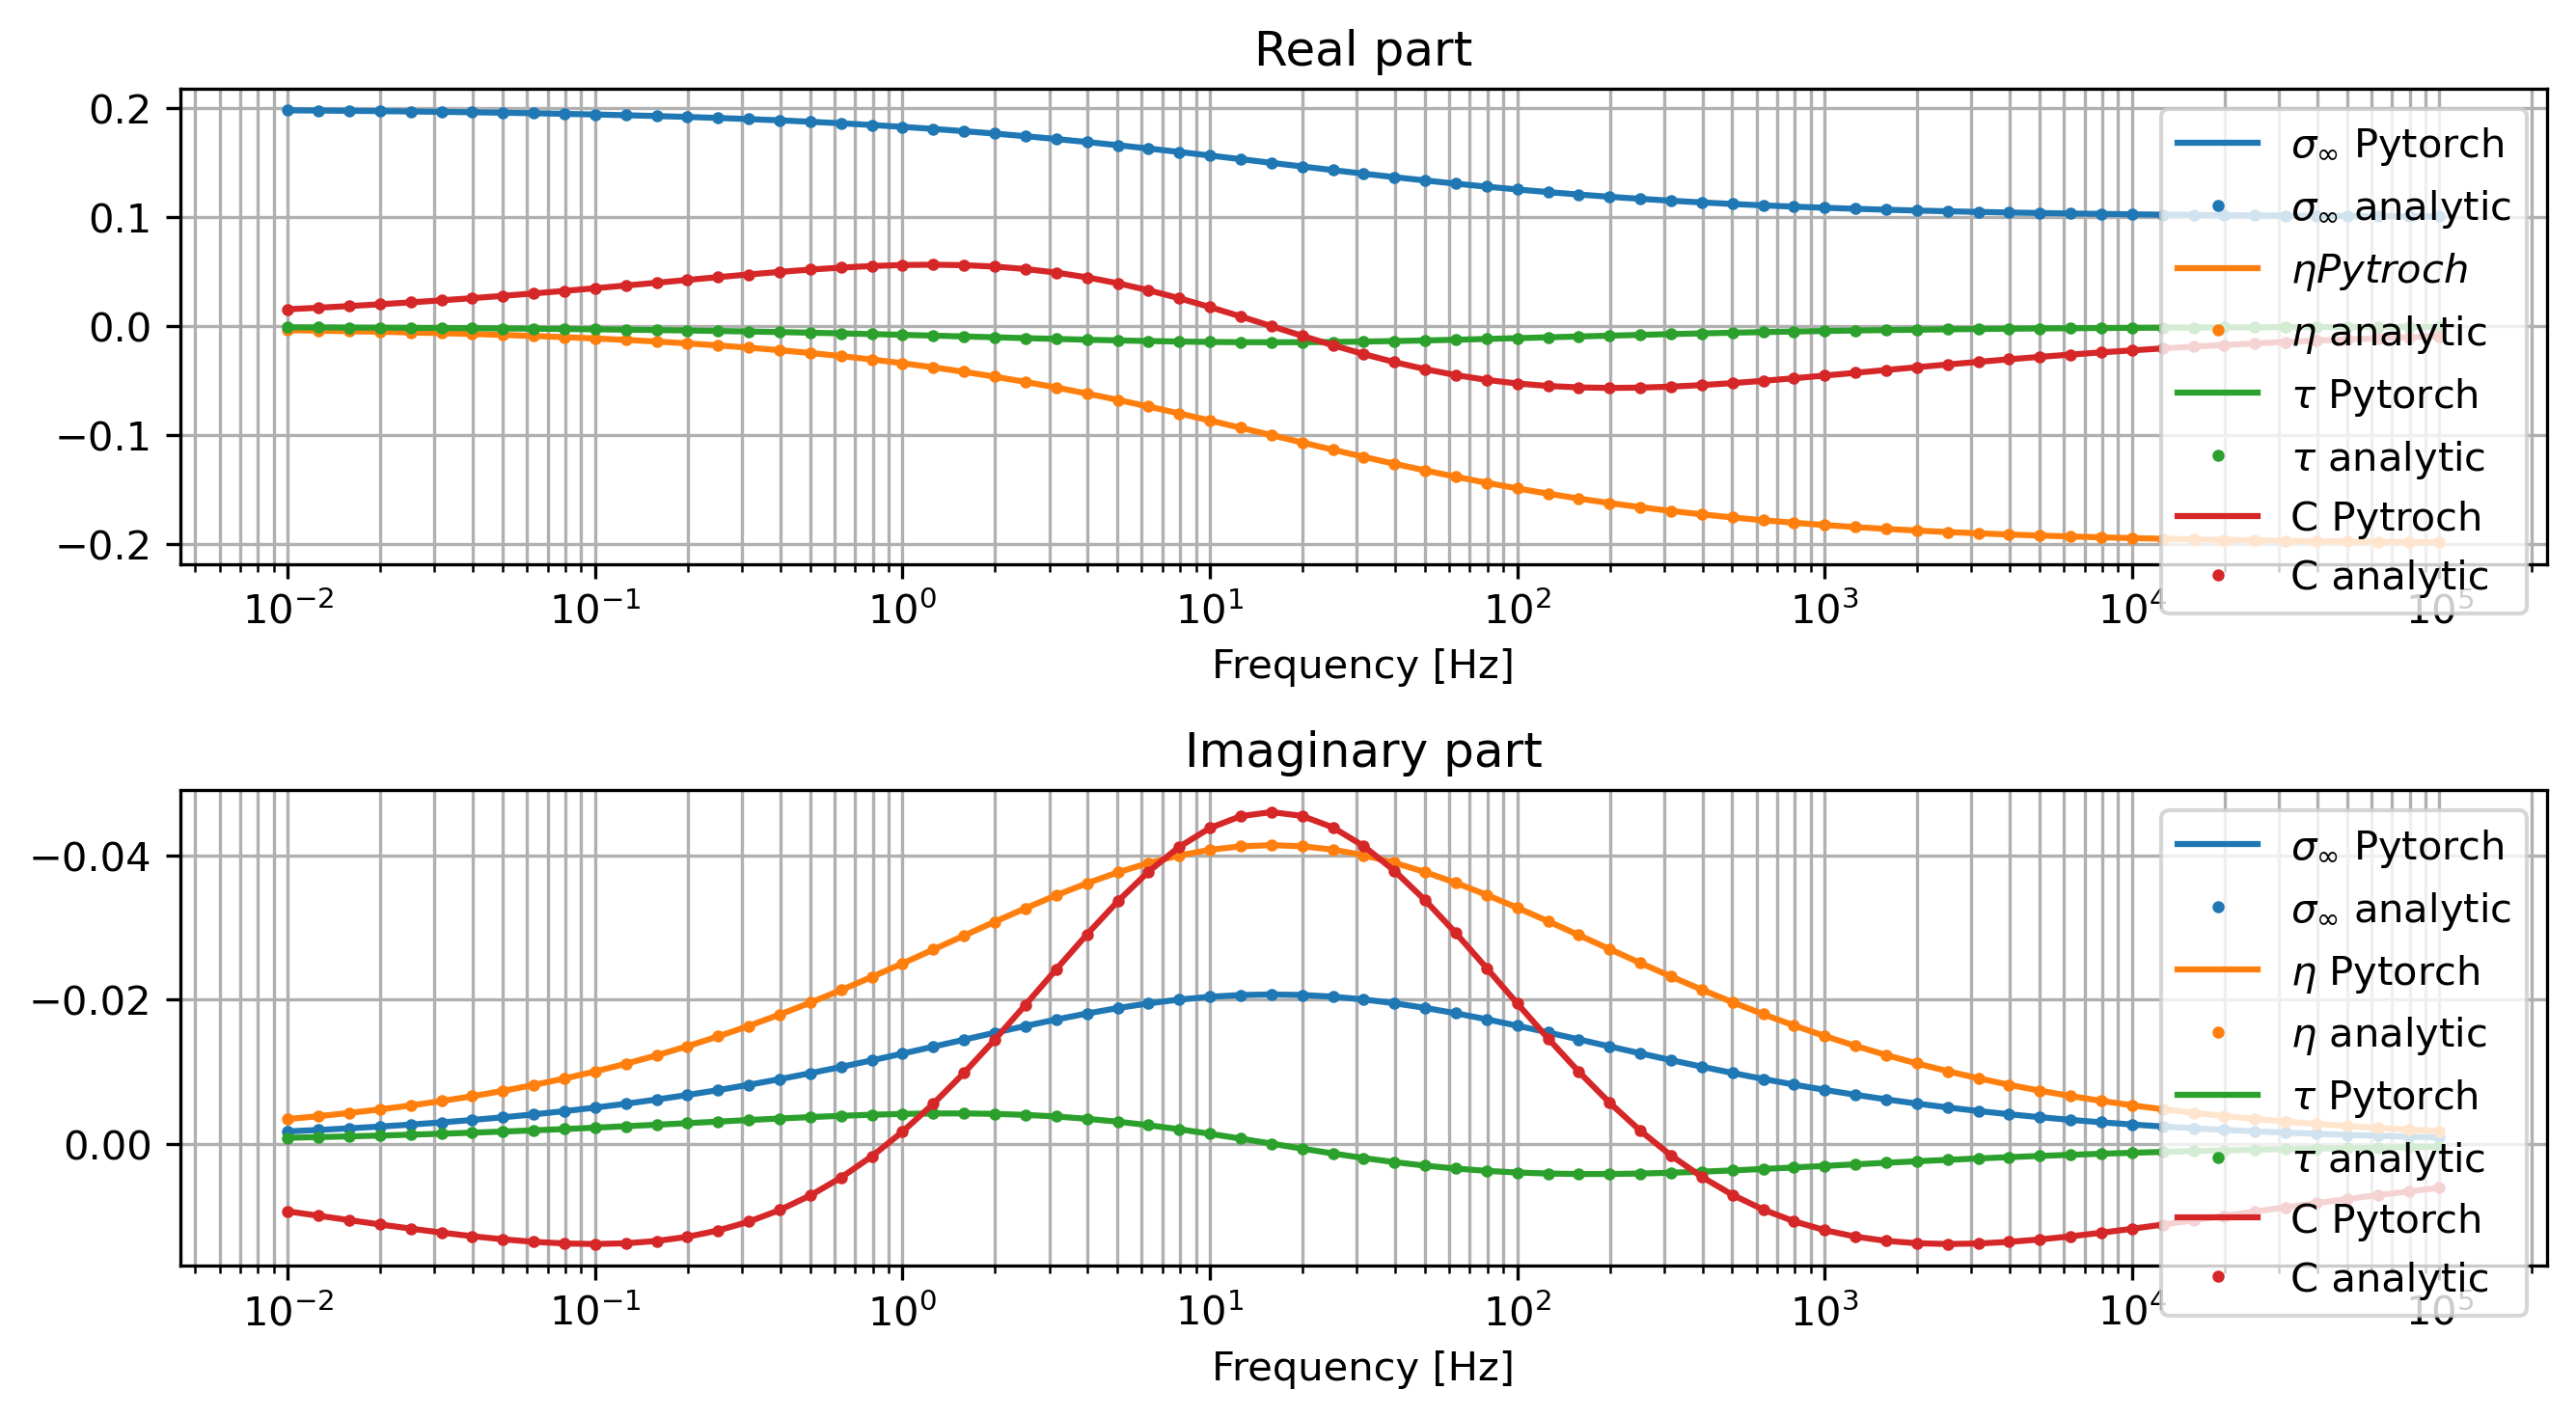

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(9, 5),dpi=300)

ax[0].semilogx(freq, J_torch_real[:,0],color = "C0", label=r"$\sigma_\infty$ Pytorch")
ax[0].semilogx(freq, J_np_real[:,0], color = "C0",
            linestyle="",markersize=4.0, marker=".", label=r"$\sigma_\infty$ analytic")
ax[0].semilogx(freq, J_torch_real[:,1],color = "C1", label=r"$\eta Pytroch$")
ax[0].semilogx(freq, J_np_real[:,1], color = "C1",
            linestyle="",markersize=4.0, marker=".", label=r"$\eta$ analytic")
ax[0].semilogx(freq, J_torch_real[:,2],color = "C2", label=r"$\tau$ Pytorch")
ax[0].semilogx(freq, J_np_real[:,2], color = "C2",
            linestyle="",markersize=4.0, marker=".", label=r"$\tau$ analytic")
ax[0].semilogx(freq, J_torch_real[:,3],color = "C3", label="C Pytroch")
ax[0].semilogx(freq, J_np_real[:,3], color = "C3",
            linestyle="",markersize=4.0, marker=".", label="C analytic")

ax[1].semilogx(freq, J_torch_imag[:,0],color = "C0", label=r"$\sigma_\infty$ Pytorch")
ax[1].semilogx(freq, J_np_imag[:,0], color = "C0",
            linestyle="",markersize=4.0, marker=".", label=r"$\sigma_\infty$ analytic")
ax[1].semilogx(freq, J_torch_imag[:,1],color = "C1", label=r"$\eta$ Pytorch")
ax[1].semilogx(freq, J_np_imag[:,1], color = "C1",
            linestyle="",markersize=4.0, marker=".", label=r"$\eta$ analytic")
ax[1].semilogx(freq, J_torch_imag[:,2],color = "C2", label=r"$\tau$ Pytorch")
ax[1].semilogx(freq, J_np_imag[:,2], color = "C2",
            linestyle="",markersize=4.0, marker=".", label=r"$\tau$ analytic")
ax[1].semilogx(freq, J_torch_imag[:,3],color = "C3", label="C Pytorch")
ax[1].semilogx(freq, J_np_imag[:,3], color = "C3",
            linestyle="",markersize=4.0, marker=".", label="C analytic")
ax[1].invert_yaxis()

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_title("Real part")
ax[1].set_title("Imaginary part")
plt.tight_layout()
plt.savefig("30_AuoDiffValid_Pelton_sip_J.jpg", dpi=300)

# ColeCole model to compute resistivity

In [13]:
parm_true = torch.tensor([np.log(con8), eta, np.log(taucc), expc], dtype=torch.float32, requires_grad=False)
model_obs = np.r_[np.log(con8), eta, np.log(taucc), expc]

In [14]:
# simulate for Pytroch
# IP_model = Pelton(freq=freq, con=True)
IP_model = ColeCole(freq=freq, res=True)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
dpred_torch = sim.dpred(parm_true)
J_torch = sim.J(parm_true)
dpred_torch_real = dpred_torch[:nfreq].detach().numpy()
dpred_torch_imag = dpred_torch[nfreq:].detach().numpy()
J_torch_real = J_torch[:nfreq, :].detach().numpy()
J_torch_imag = J_torch[nfreq:, :].detach().numpy()
dpred_cc_real = dpred_torch_real
dpred_cc_imag = dpred_torch_imag
J_cc_real = J_torch_real
J_cc_imag = J_torch_imag
# simulate for numpy which has analytic derivative
# IP_model_np = Pelton_res_f_np(freq=freq, con=True)
IP_model_np = ColeCole_con_f_np(freq=freq, res=True)
sim_np = IP_sim_np(ip_model=IP_model_np, mode="sip")
dpred_np = sim_np.dpred(model_obs)
J_np = sim_np.J(model_obs)
dpred_np_real = dpred_np[:nfreq]
dpred_np_imag = dpred_np[nfreq:]
J_np_real = J_np[:nfreq, :]
J_np_imag = J_np[nfreq:, :]


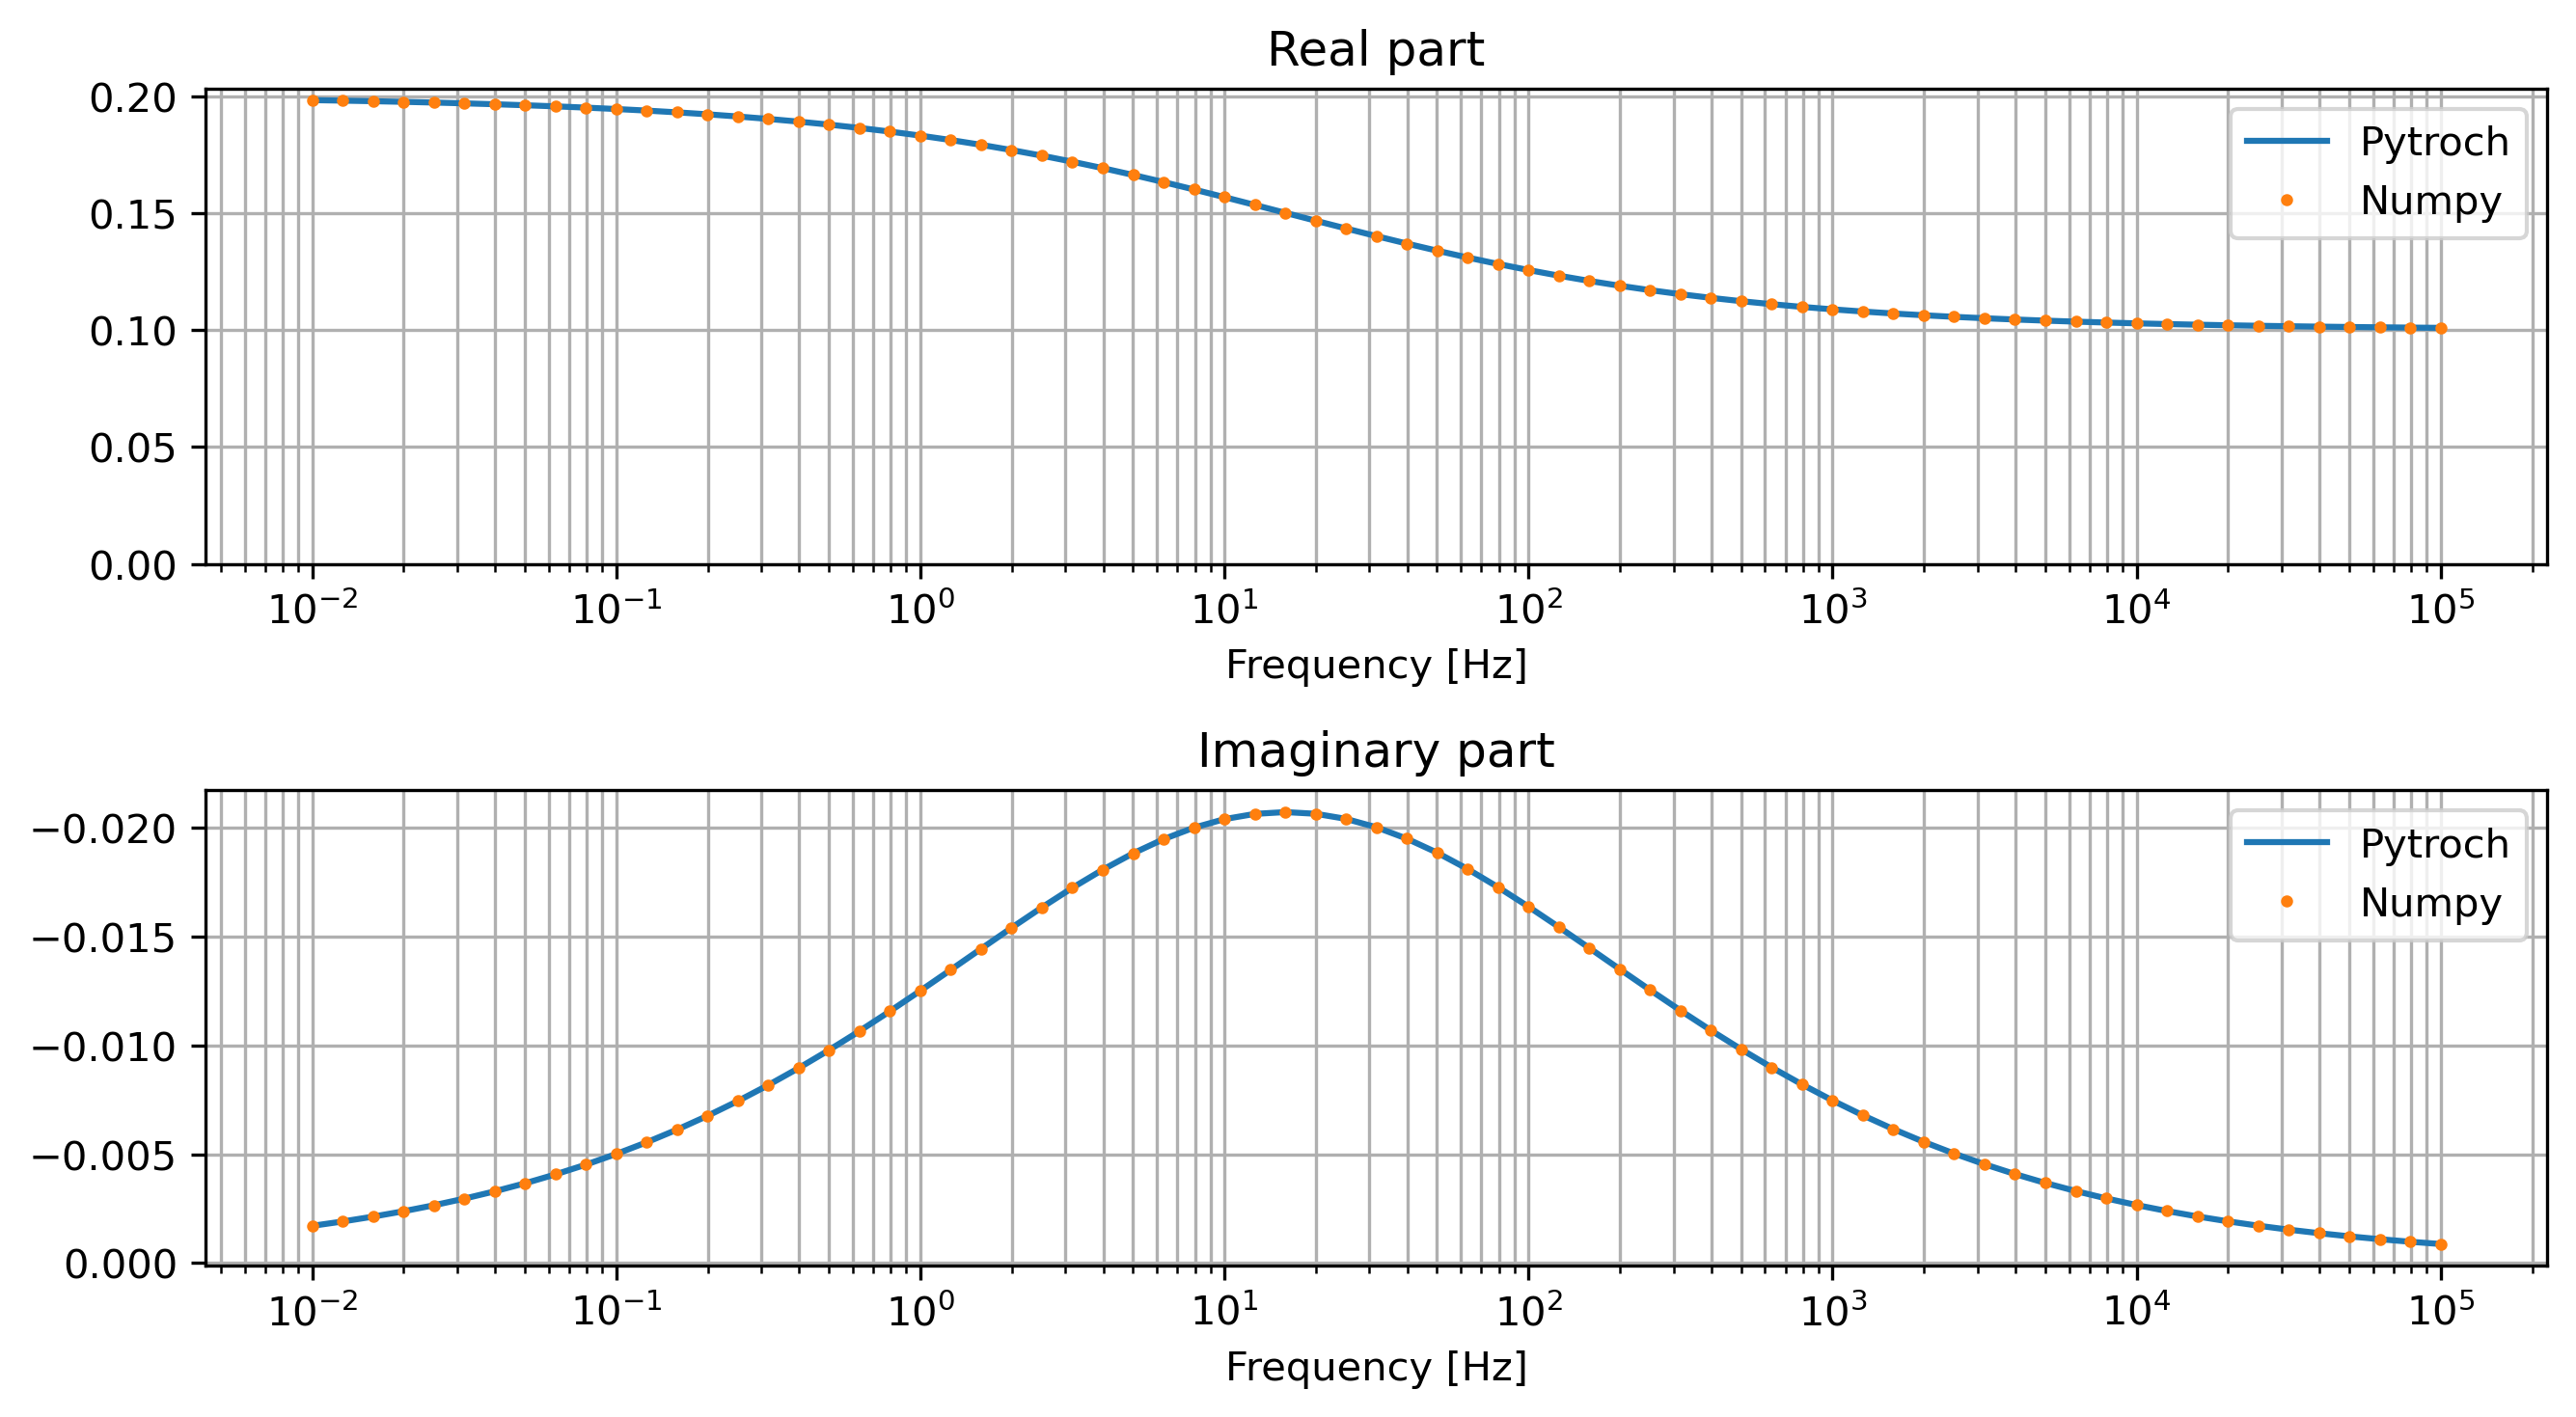

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(9, 5),dpi=300)

ax[0].semilogx(freq, dpred_torch_real,color = "C0",label="Pytroch")
ax[0].semilogx(freq, dpred_np_real, color = "C1",
              linestyle="",markersize=4.0, marker=".",label="Numpy")
ax[0].set_ylim(bottom=0)

ax[1].semilogx (freq, dpred_torch_imag, color = "C0",label="Pytroch")
ax[1].semilogx(freq, dpred_np_imag,  color = "C1",               
              linestyle="",markersize=4.0, marker=".",label="Numpy")
ax[1].invert_yaxis()
# ax[2].plot(dpred_torch_real, -dpred_torch_imag, color="C0", label="Pytroch")
# ax[2].plot(dpred_np_real, -dpred_np_imag, color="C1",
#               linestyle="",markersize=4.0, marker=".",label="Numpy")
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_title("Real part")
ax[1].set_title("Imaginary part")
# ax[2].set_title("Cole-Cole plot")
# ax[2].set_xlabel("Real")
# ax[2].set_ylabel("-Imaginary")
plt.tight_layout()
plt.savefig("30_AuoDiffValid_Cole_res_sip.jpg", dpi=300)

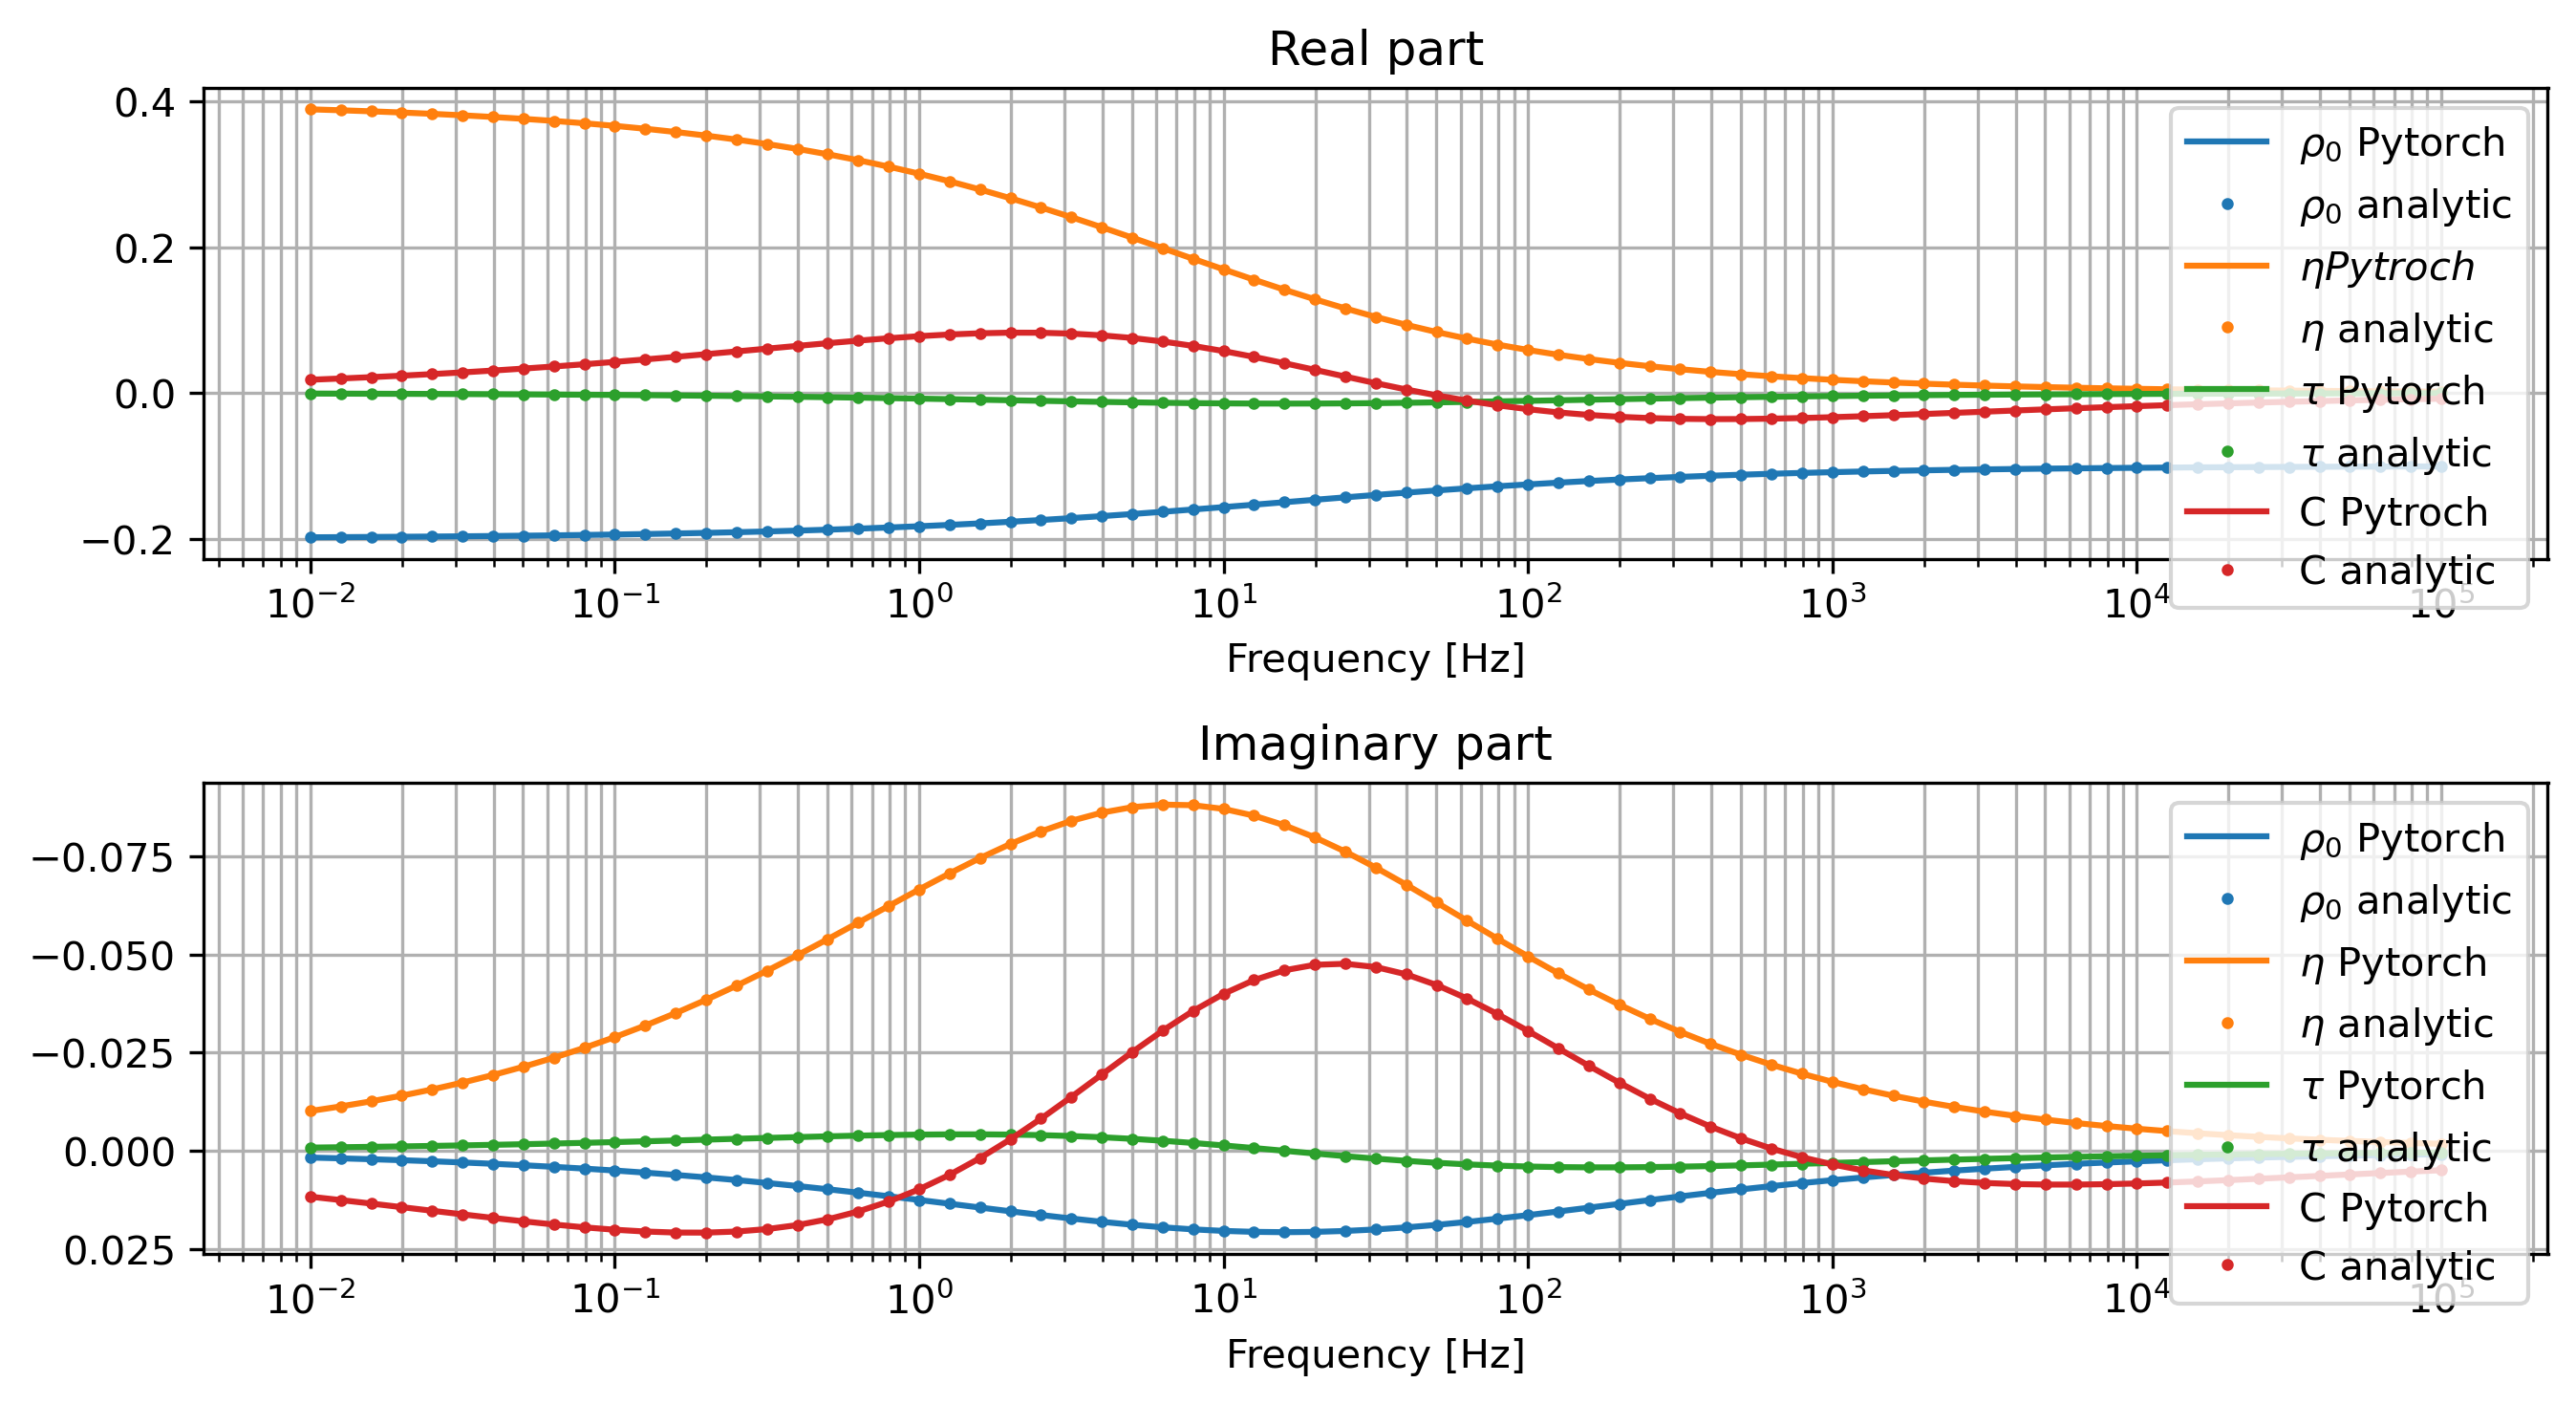

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(9, 5),dpi=300)

ax[0].semilogx(freq, J_torch_real[:,0],color = "C0", label=r"$\rho_0$ Pytorch")
ax[0].semilogx(freq, J_np_real[:,0], color = "C0",
            linestyle="",markersize=4.0, marker=".", label=r"$\rho_0$ analytic")
ax[0].semilogx(freq, J_torch_real[:,1],color = "C1", label=r"$\eta Pytroch$")
ax[0].semilogx(freq, J_np_real[:,1], color = "C1",
            linestyle="",markersize=4.0, marker=".", label=r"$\eta$ analytic")
ax[0].semilogx(freq, J_torch_real[:,2],color = "C2", label=r"$\tau$ Pytorch")
ax[0].semilogx(freq, J_np_real[:,2], color = "C2",
            linestyle="",markersize=4.0, marker=".", label=r"$\tau$ analytic")
ax[0].semilogx(freq, J_torch_real[:,3],color = "C3", label="C Pytroch")
ax[0].semilogx(freq, J_np_real[:,3], color = "C3",
            linestyle="",markersize=4.0, marker=".", label="C analytic")

ax[1].semilogx(freq, J_torch_imag[:,0],color = "C0", label=r"$\rho_0$ Pytorch")
ax[1].semilogx(freq, J_np_imag[:,0], color = "C0",
            linestyle="",markersize=4.0, marker=".", label=r"$\rho_0$ analytic")
ax[1].semilogx(freq, J_torch_imag[:,1],color = "C1", label=r"$\eta$ Pytorch")
ax[1].semilogx(freq, J_np_imag[:,1], color = "C1",
            linestyle="",markersize=4.0, marker=".", label=r"$\eta$ analytic")
ax[1].semilogx(freq, J_torch_imag[:,2],color = "C2", label=r"$\tau$ Pytorch")
ax[1].semilogx(freq, J_np_imag[:,2], color = "C2",
            linestyle="",markersize=4.0, marker=".", label=r"$\tau$ analytic")
ax[1].semilogx(freq, J_torch_imag[:,3],color = "C3", label="C Pytorch")
ax[1].semilogx(freq, J_np_imag[:,3], color = "C3",
            linestyle="",markersize=4.0, marker=".", label="C analytic")
ax[1].invert_yaxis()
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_title("Real part")
ax[1].set_title("Imaginary part")
plt.tight_layout()
plt.savefig("30_AuoDiffValid_Cole_res_sip_J.jpg", dpi=300)

# Compare the Pelton and Cole-Cole

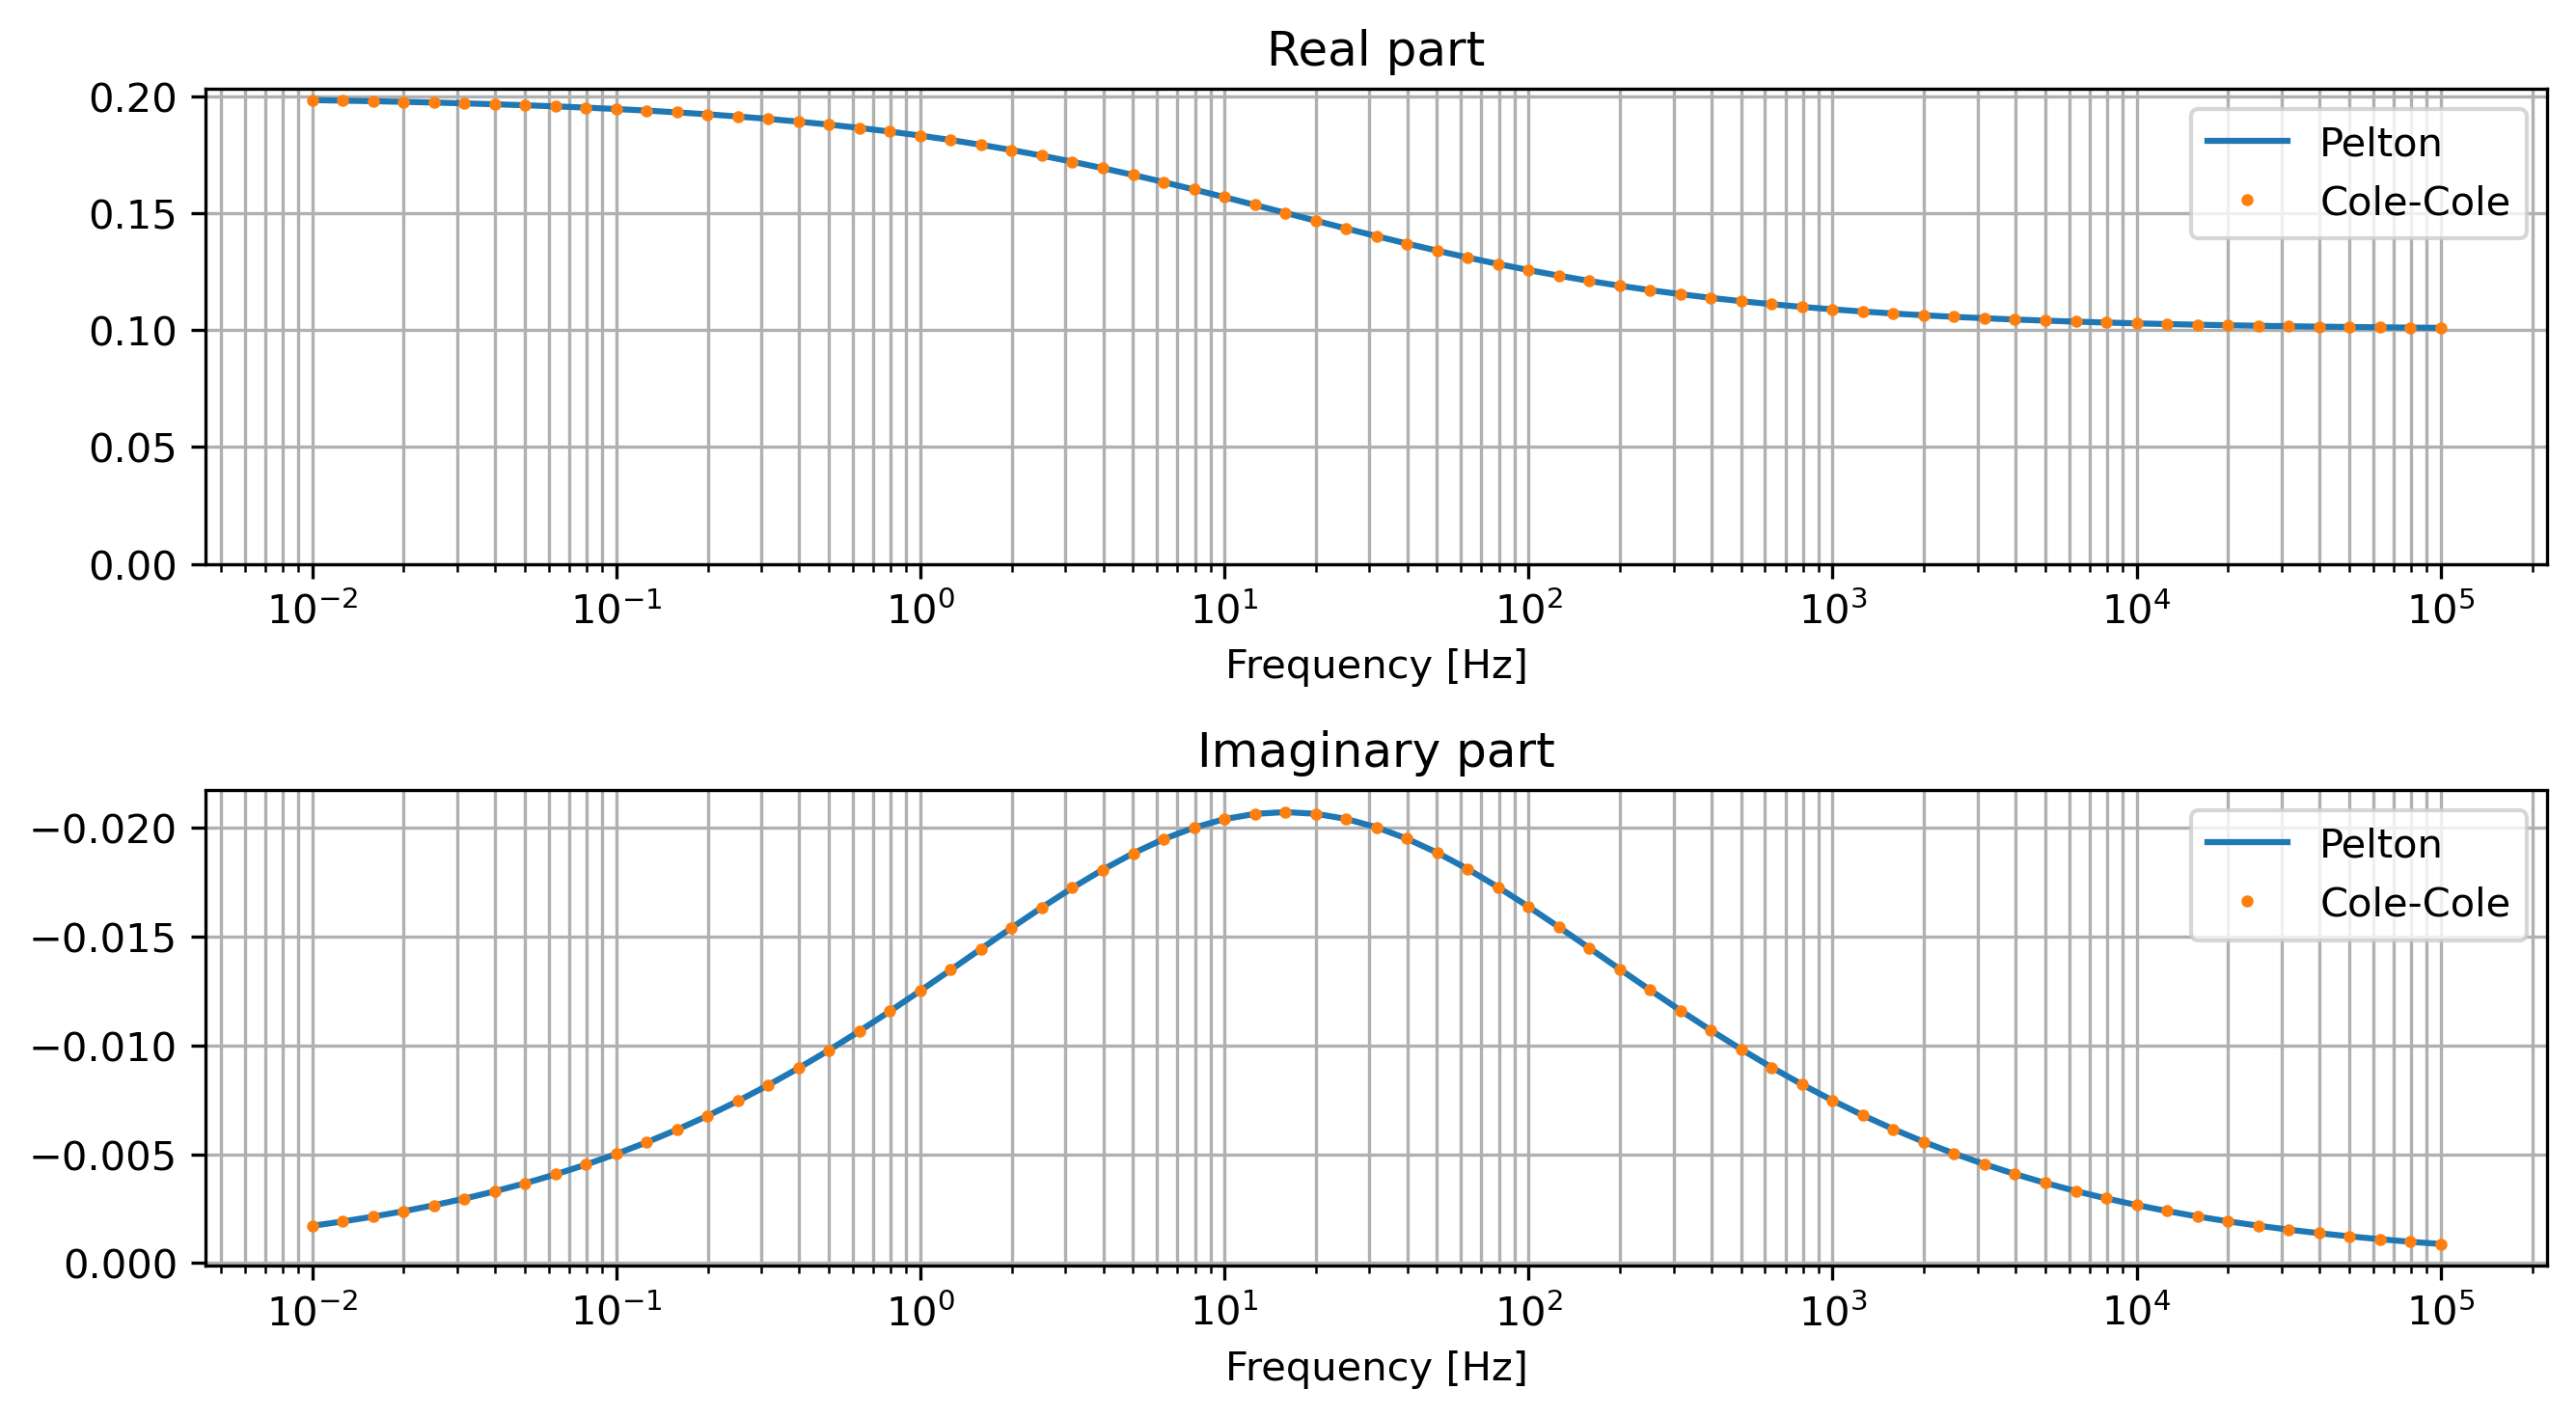

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(9, 5),dpi=300)

ax[0].semilogx(freq, dpred_pel_real,color = "C0",label="Pelton")
ax[0].semilogx(freq, dpred_cc_real, color = "C1",
              linestyle="",markersize=4.0, marker=".",label="Cole-Cole")
ax[0].set_ylim(bottom=0)

ax[1].semilogx (freq, dpred_pel_imag, color = "C0",label="Pelton")
ax[1].semilogx(freq, dpred_cc_imag,  color = "C1",               
              linestyle="",markersize=4.0, marker=".",label="Cole-Cole")
ax[1].invert_yaxis()
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_title("Real part")
ax[1].set_title("Imaginary part")
plt.tight_layout()
plt.savefig("30_AuoDiffValid_Cole_Pel_sip.jpg", dpi=300)

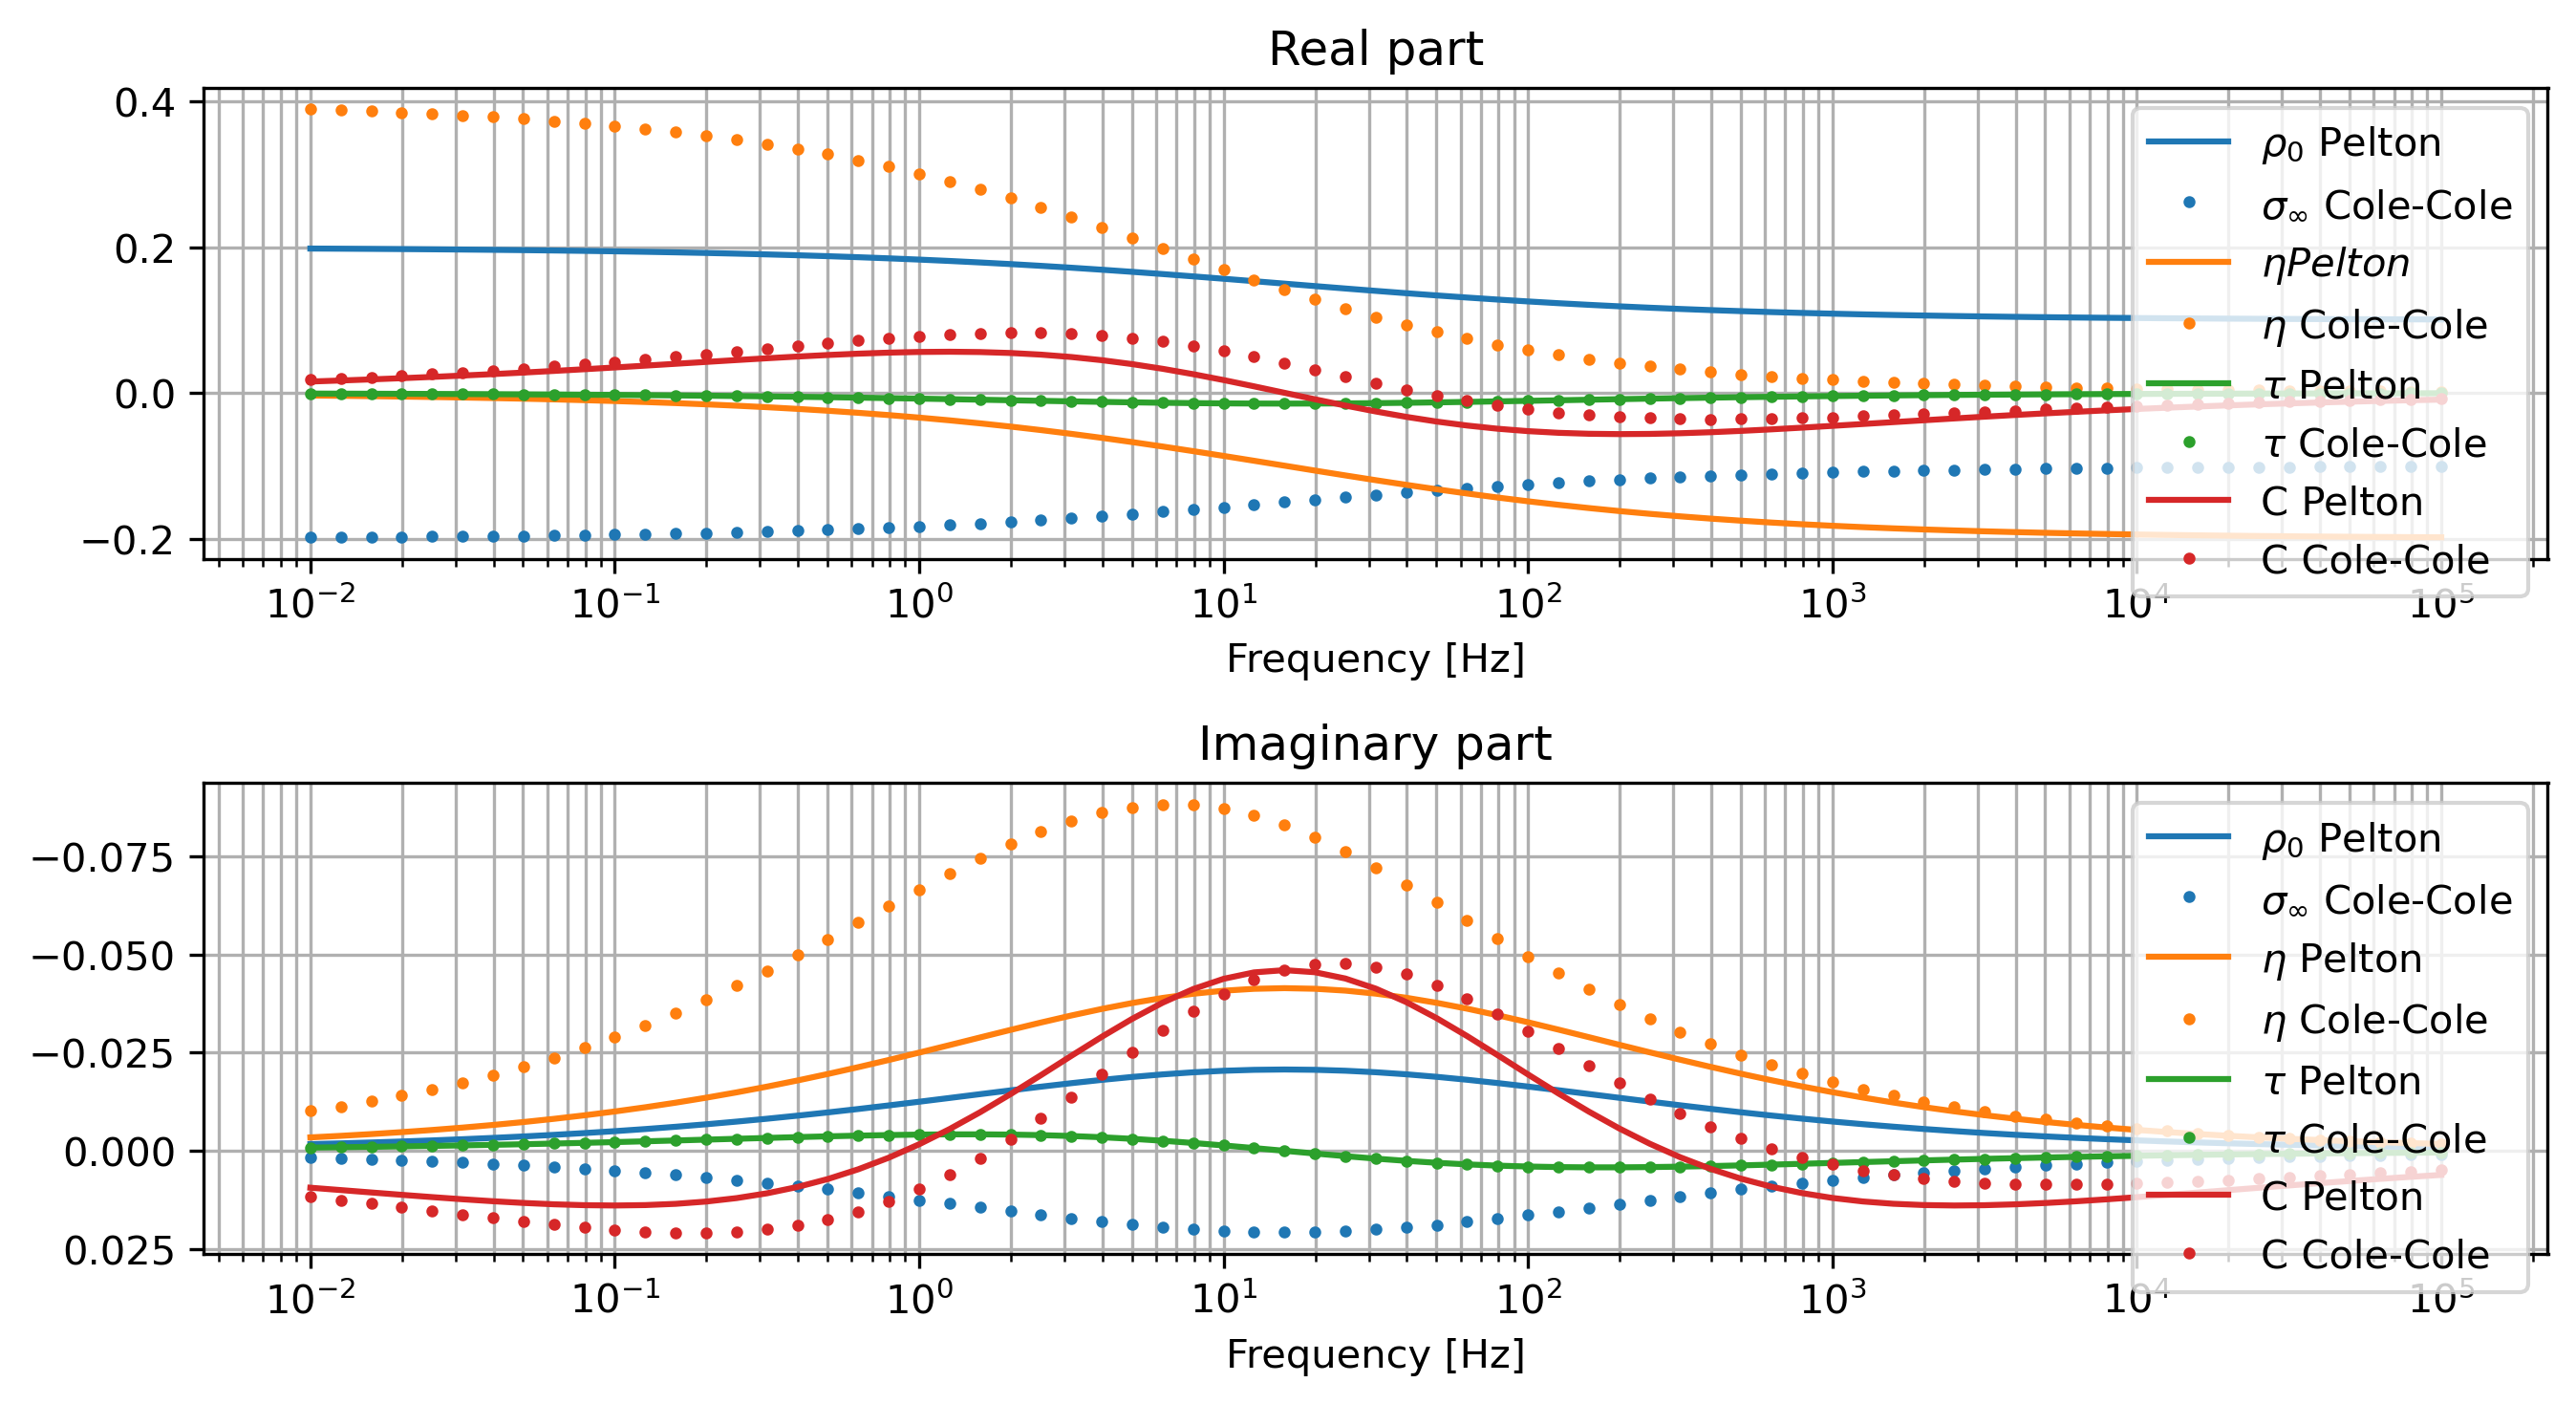

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(9, 5),dpi=300)

ax[0].semilogx(freq, J_pel_real[:,0],color = "C0", label=r"$\rho_0$ Pelton")
ax[0].semilogx(freq, J_cc_real[:,0], color = "C0",
            linestyle="",markersize=4.0, marker=".", label=r"$\sigma_\infty$ Cole-Cole")
ax[0].semilogx(freq, J_pel_real[:,1],color = "C1", label=r"$\eta Pelton$")
ax[0].semilogx(freq, J_cc_real[:,1], color = "C1",
            linestyle="",markersize=4.0, marker=".", label=r"$\eta$ Cole-Cole")
ax[0].semilogx(freq, J_pel_real[:,2],color = "C2", label=r"$\tau$ Pelton")
ax[0].semilogx(freq, J_cc_real[:,2], color = "C2",
            linestyle="",markersize=4.0, marker=".", label=r"$\tau$ Cole-Cole")
ax[0].semilogx(freq, J_pel_real[:,3],color = "C3", label="C Pelton")
ax[0].semilogx(freq, J_cc_real[:,3], color = "C3",
            linestyle="",markersize=4.0, marker=".", label="C Cole-Cole")

ax[1].semilogx(freq, J_pel_imag[:,0],color = "C0", label=r"$\rho_0$ Pelton")
ax[1].semilogx(freq, J_cc_imag[:,0], color = "C0",
            linestyle="",markersize=4.0, marker=".", label=r"$\sigma_\infty$ Cole-Cole")
ax[1].semilogx(freq, J_pel_imag[:,1],color = "C1", label=r"$\eta$ Pelton")
ax[1].semilogx(freq, J_cc_imag[:,1], color = "C1",
            linestyle="",markersize=4.0, marker=".", label=r"$\eta$ Cole-Cole")
ax[1].semilogx(freq, J_pel_imag[:,2],color = "C2", label=r"$\tau$ Pelton")
ax[1].semilogx(freq, J_cc_imag[:,2], color = "C2",
            linestyle="",markersize=4.0, marker=".", label=r"$\tau$ Cole-Cole")
ax[1].semilogx(freq, J_pel_imag[:,3],color = "C3", label="C Pelton")
ax[1].semilogx(freq, J_cc_imag[:,3], color = "C3",
            linestyle="",markersize=4.0, marker=".", label="C Cole-Cole")

ax[1].invert_yaxis()
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_title("Real part")
ax[1].set_title("Imaginary part")
plt.tight_layout()
plt.savefig("30_AuoDiffValid_Cole_Pel_sip_J.jpg", dpi=300)

# Debye Decomposition Model

In [19]:
ntau= 9
taus_start_log10 =  -6
taus_end_log10 =2
taus = np.logspace(taus_start_log10,taus_end_log10,ntau)
print(taus)

[1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


In [20]:
etas_base = eta/ntau
parm_true = torch.tensor(
    np.r_[np.log(res0), etas_base*np.ones(ntau)],
    dtype=torch.float32,
    requires_grad=True
)
model_obs = np.r_[np.log(res0), etas_base*np.ones(ntau)]

In [21]:
# simulate for Pytroch
# IP_model = Pelton(freq=freq, con=True)
IP_model = Debye_Sum_Ser_f(freq=freq, taus=taus)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
dpred_torch = sim.dpred(parm_true)
J_torch = sim.J(parm_true)
dpred_torch_real = dpred_torch[:nfreq].detach().numpy()
dpred_torch_imag = dpred_torch[nfreq:].detach().numpy()
J_torch_real = J_torch[:nfreq, :].detach().numpy()
J_torch_imag = J_torch[nfreq:, :].detach().numpy()
dpred_ddr_real = dpred_torch_real
dpred_ddr_imag = dpred_torch_imag
J_ddr_real = J_torch_real
J_ddr_imag = J_torch_imag
# simulate for numpy which has analytic derivative
# IP_model_np = Pelton_res_f_np(freq=freq, con=True)
IP_model_np = DDR_f_np(freq=freq, taus=taus)
sim_np = IP_sim_np(ip_model=IP_model_np, mode="sip")
dpred_np = sim_np.dpred(model_obs)
J_np = sim_np.J(model_obs)
dpred_np_real = dpred_np[:nfreq]
dpred_np_imag = dpred_np[nfreq:]
J_np_real = J_np[:nfreq, :]
J_np_imag = J_np[nfreq:, :]


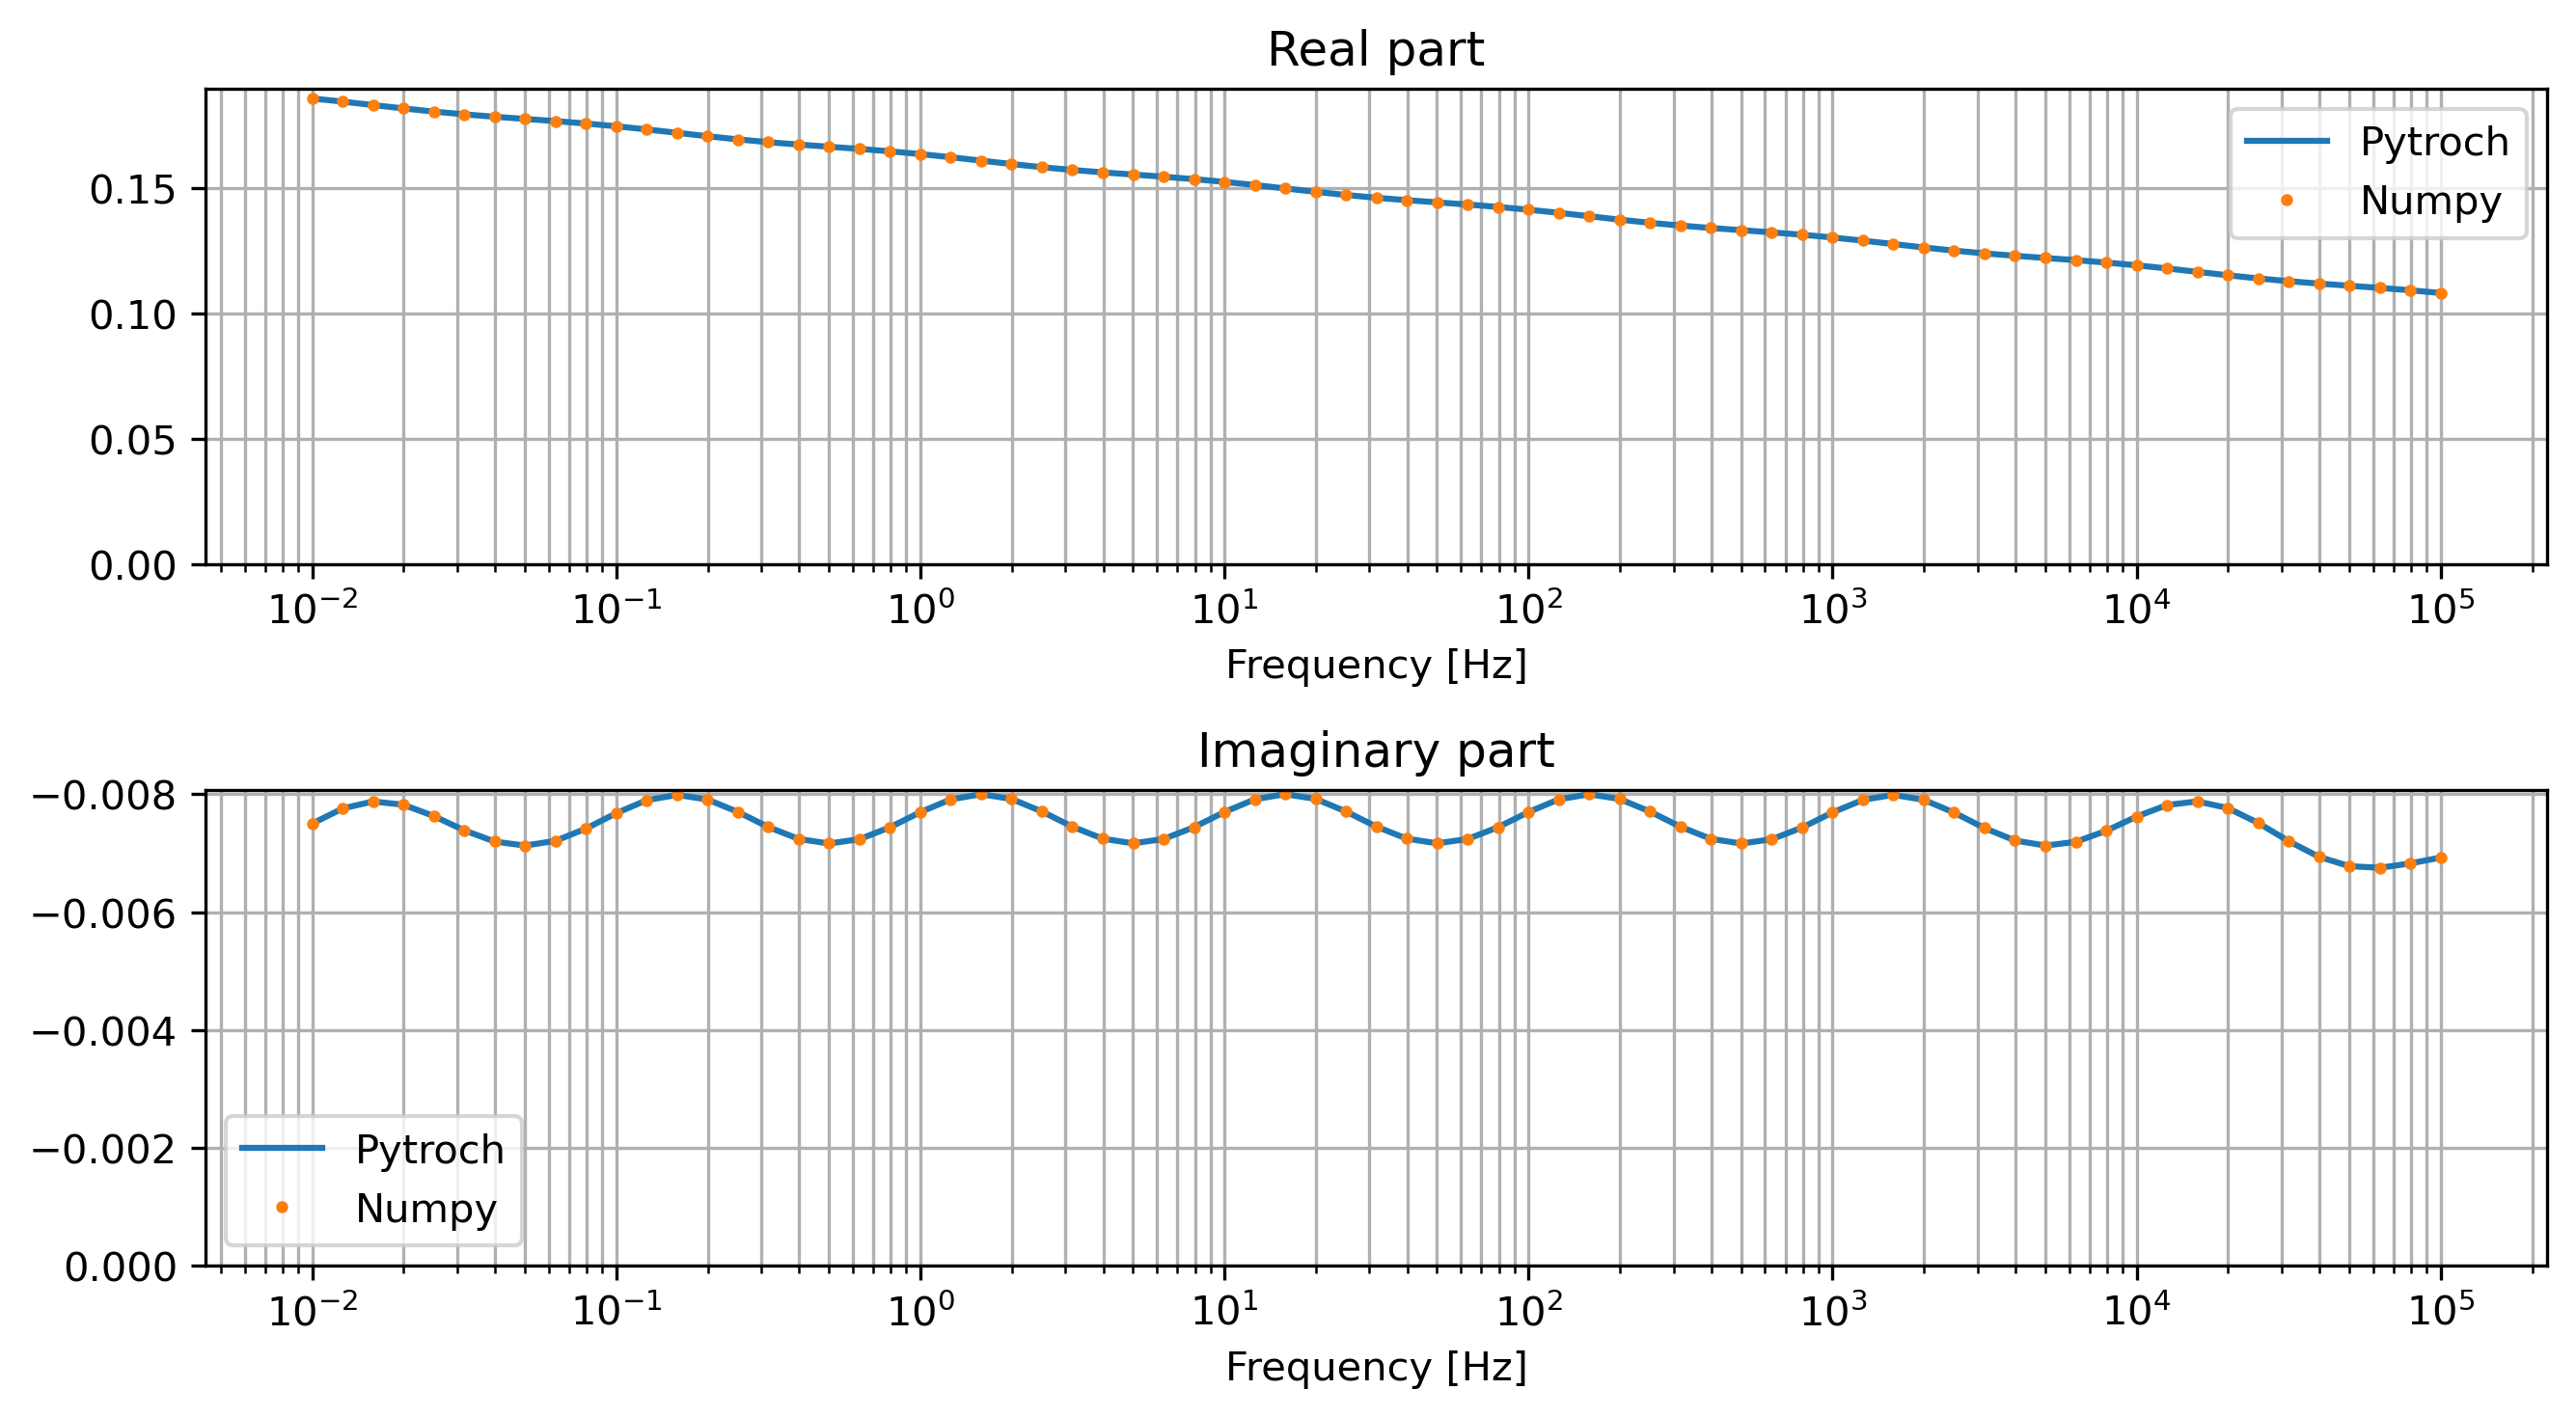

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(9, 5),dpi=300)

ax[0].semilogx(freq, dpred_torch_real,color = "C0",label="Pytroch")
ax[0].semilogx(freq, dpred_np_real, color = "C1",
              linestyle="",markersize=4.0, marker=".",label="Numpy")
ax[0].set_ylim(bottom=0)

ax[1].semilogx (freq, dpred_torch_imag, color = "C0",label="Pytroch")
ax[1].semilogx(freq, dpred_np_imag,  color = "C1",               
              linestyle="",markersize=4.0, marker=".",label="Numpy")
ax[1].invert_yaxis()
ax[1].set_ylim(bottom=0)
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_title("Real part")
ax[1].set_title("Imaginary part")

plt.tight_layout()
plt.savefig("30_AuoDiffValid_DDR_sip.jpg", dpi=300)

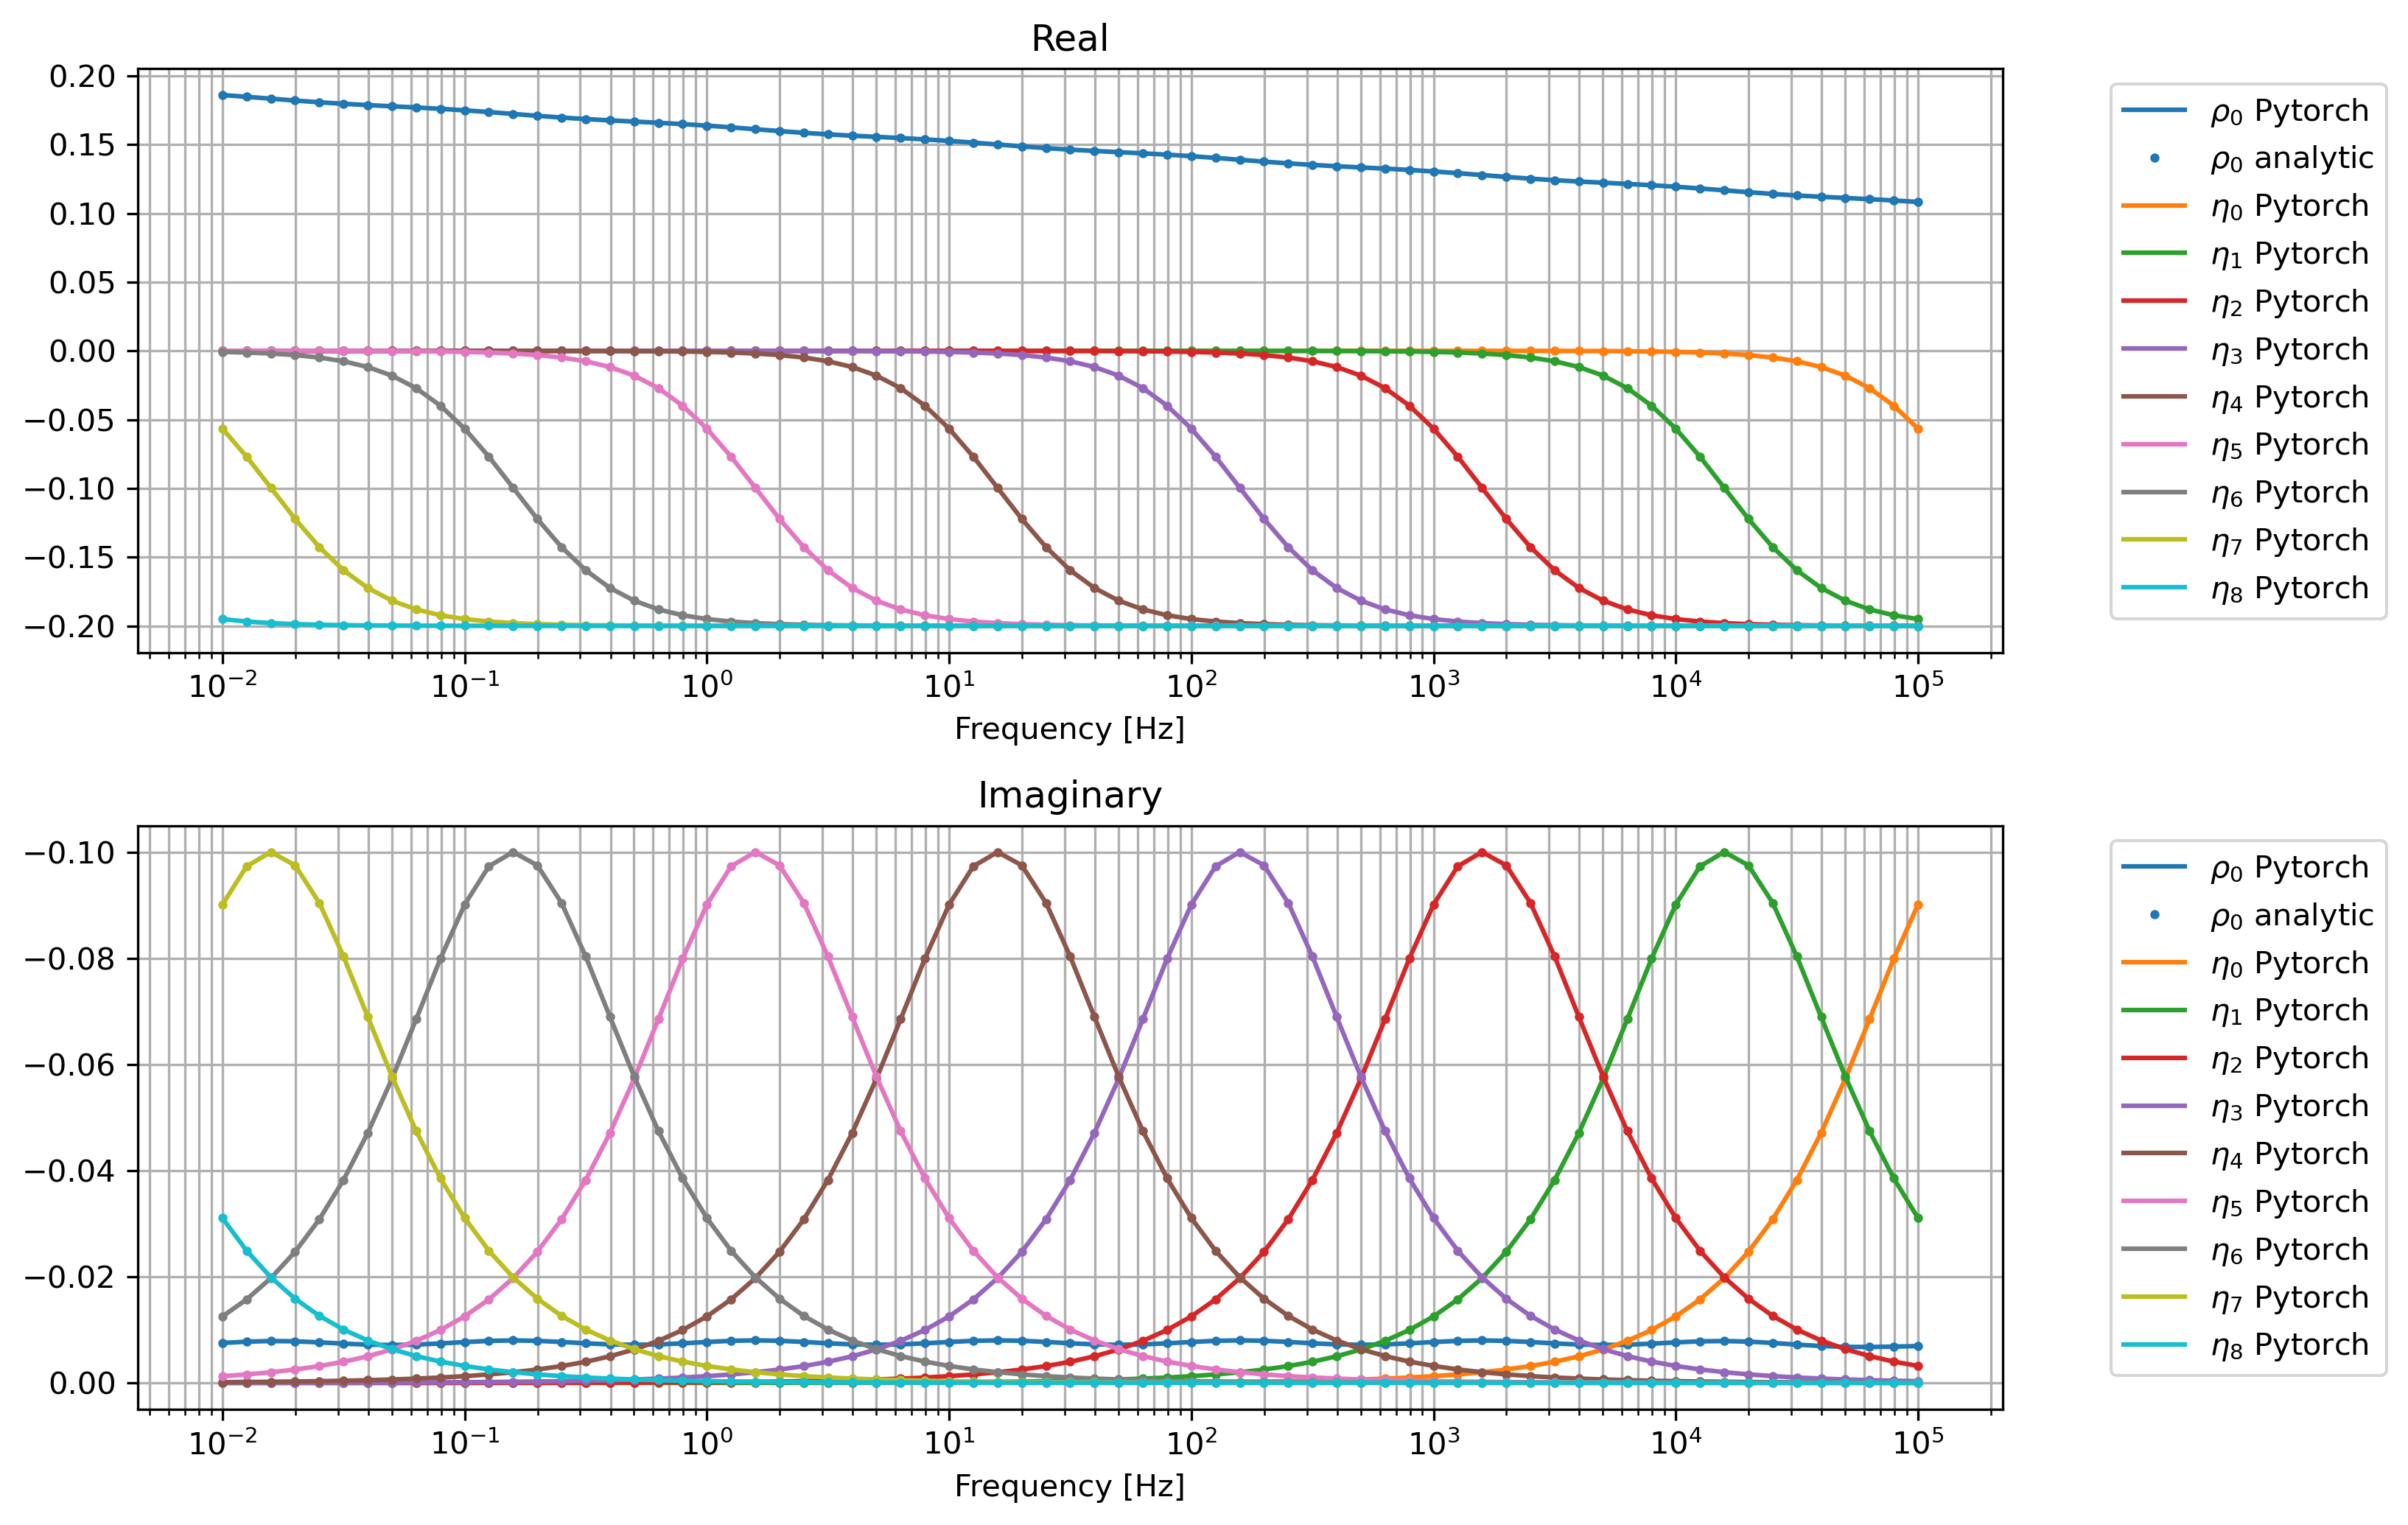

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(11, 7),dpi=300)

ax[0].semilogx(freq, J_torch_real[:,0], color="C0", 
               label=r"$\rho_0$ Pytorch")
ax[0].semilogx(freq, J_np_real[:,0], color="C0",
            linestyle="",markersize=4.0, marker=".", label=r"$\rho_0$ analytic")
ax[1].semilogx(freq, J_torch_imag[:,0], color="C0",
               label=r"$\rho_0$ Pytorch")
ax[1].semilogx(freq, J_np_imag[:,0], color="C0",
            linestyle="",markersize=4.0, marker=".", label=r"$\rho_0$ analytic")
for i in range(ntau):
    ax[0].semilogx(freq, J_torch_real[:,i+1], color=f"C{i+1}", 
                   label=f"$\eta_{i}$ Pytorch")
    ax[0].semilogx(freq, J_np_real[:,i+1], color=f"C{i+1}",
                         linestyle="",markersize=4.0, marker=".")
#     , label=f"$\eta_{i}$ analytic")
    ax[1].semilogx(freq, J_torch_imag[:,i+1], color=f"C{i+1}",
                     label=f"$\eta_{i}$ Pytorch")
    ax[1].semilogx(freq, J_np_imag[:,i+1], color=f"C{i+1}",
                         linestyle="",markersize=4.0, marker=".")
#     , 
#                          label=f"$\eta_{i}$ analytic")
ax[1].invert_yaxis()

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title('Real')
ax[1].set_title('Imaginary')
plt.tight_layout()
plt.savefig("30_AuoDiffValid_DDR_sip_J.jpg", dpi=300)

In [24]:
parm_true = torch.tensor(
    np.r_[np.log(con8), etas_base*np.ones(ntau)],
    dtype=torch.float32,
    requires_grad=True
)
model_obs = np.r_[np.log(con8), etas_base*np.ones(ntau)]

In [25]:
# simulate for Pytroch
# IP_model = Pelton(freq=freq, con=True)
IP_model = Debye_Sum_Par_f(freq=freq, taus=taus, res=True)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
dpred_torch = sim.dpred(parm_true)
J_torch = sim.J(parm_true)
dpred_torch_real = dpred_torch[:nfreq].detach().numpy()
dpred_torch_imag = dpred_torch[nfreq:].detach().numpy()
J_torch_real = J_torch[:nfreq, :].detach().numpy()
J_torch_imag = J_torch[nfreq:, :].detach().numpy()
dpred_ddr_real = dpred_torch_real
dpred_ddr_imag = dpred_torch_imag
J_ddr_real = J_torch_real
J_ddr_imag = J_torch_imag
# simulate for numpy which has analytic derivative
# IP_model_np = Pelton_res_f_np(freq=freq, con=True)
IP_model_np = DDC_f_np(freq=freq, taus=taus, res=True)
sim_np = IP_sim_np(ip_model=IP_model_np, mode="sip")
dpred_np = sim_np.dpred(model_obs)
J_np = sim_np.J(model_obs)
dpred_np_real = dpred_np[:nfreq]
dpred_np_imag = dpred_np[nfreq:]
J_np_real = J_np[:nfreq, :]
J_np_imag = J_np[nfreq:, :]


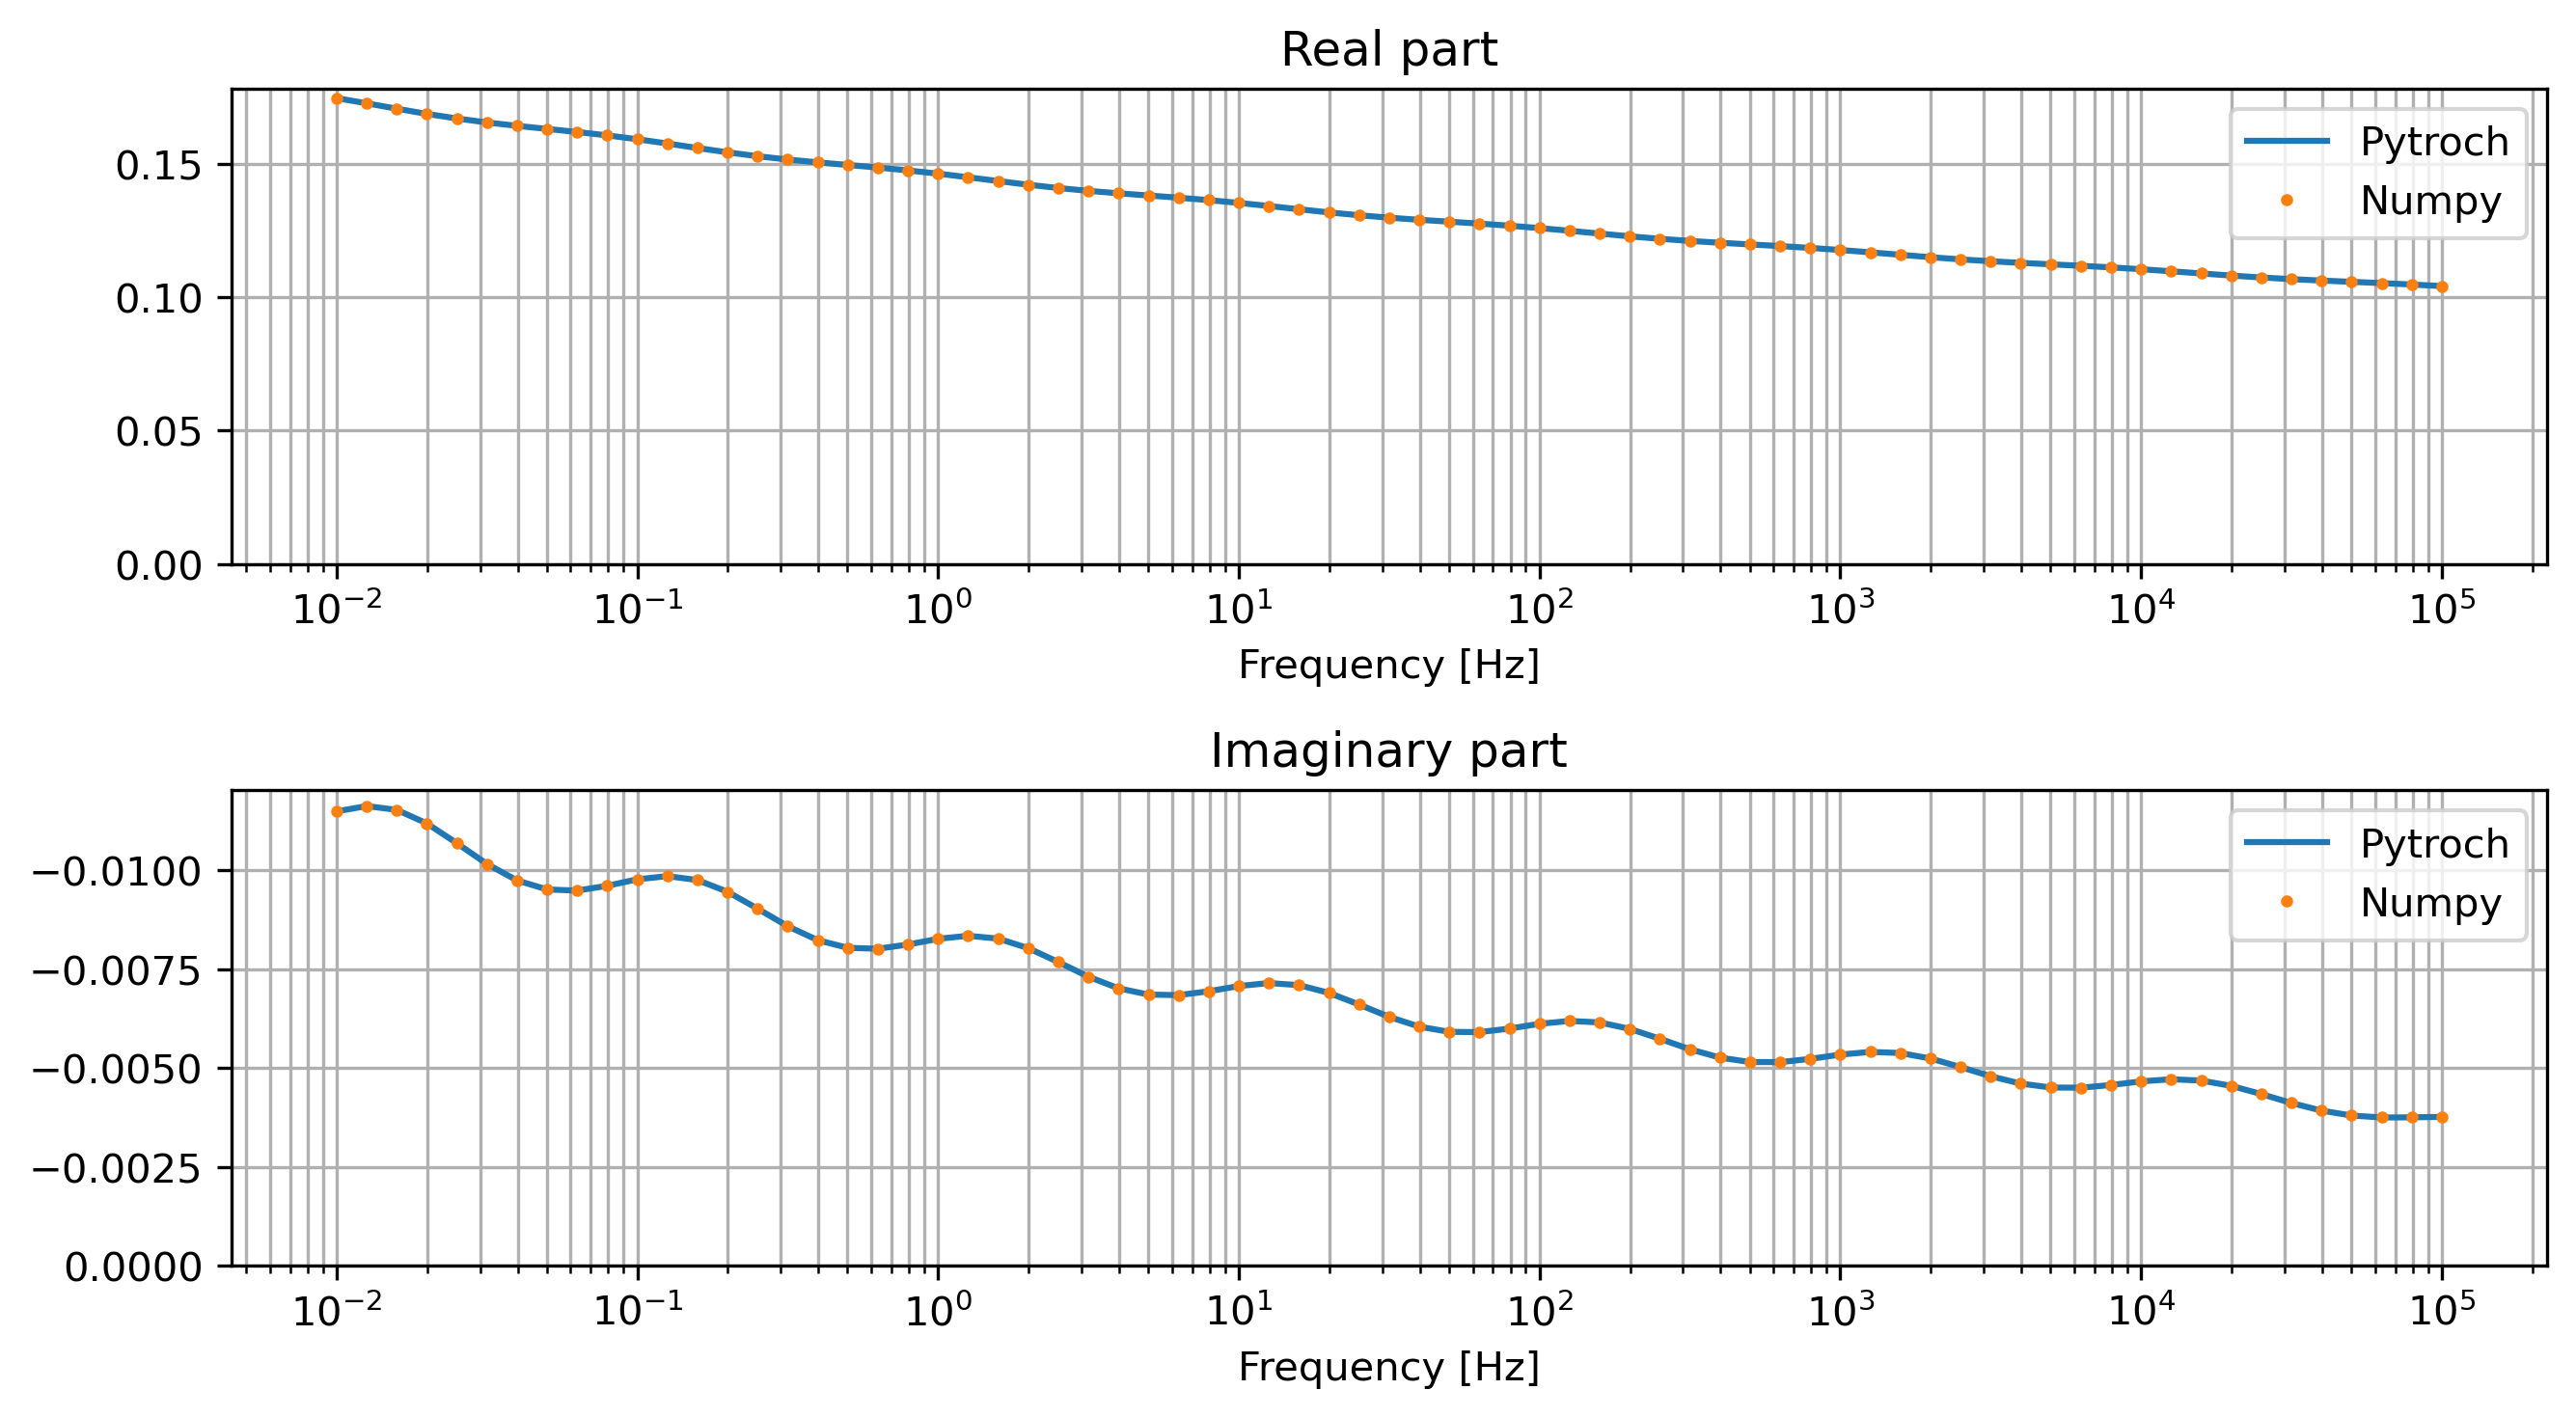

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(9, 5),dpi=300)

ax[0].semilogx(freq, dpred_torch_real,color = "C0",label="Pytroch")
ax[0].semilogx(freq, dpred_np_real, color = "C1",
              linestyle="",markersize=4.0, marker=".",label="Numpy")
ax[0].set_ylim(bottom=0)

ax[1].semilogx (freq, dpred_torch_imag, color = "C0",label="Pytroch")
ax[1].semilogx(freq, dpred_np_imag,  color = "C1",               
              linestyle="",markersize=4.0, marker=".",label="Numpy")
ax[1].invert_yaxis()
ax[1].set_ylim(bottom=0)

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_title("Real part")
ax[1].set_title("Imaginary part")

plt.tight_layout()
plt.savefig("30_AuoDiffValid_DDC_res_sip.jpg", dpi=300)

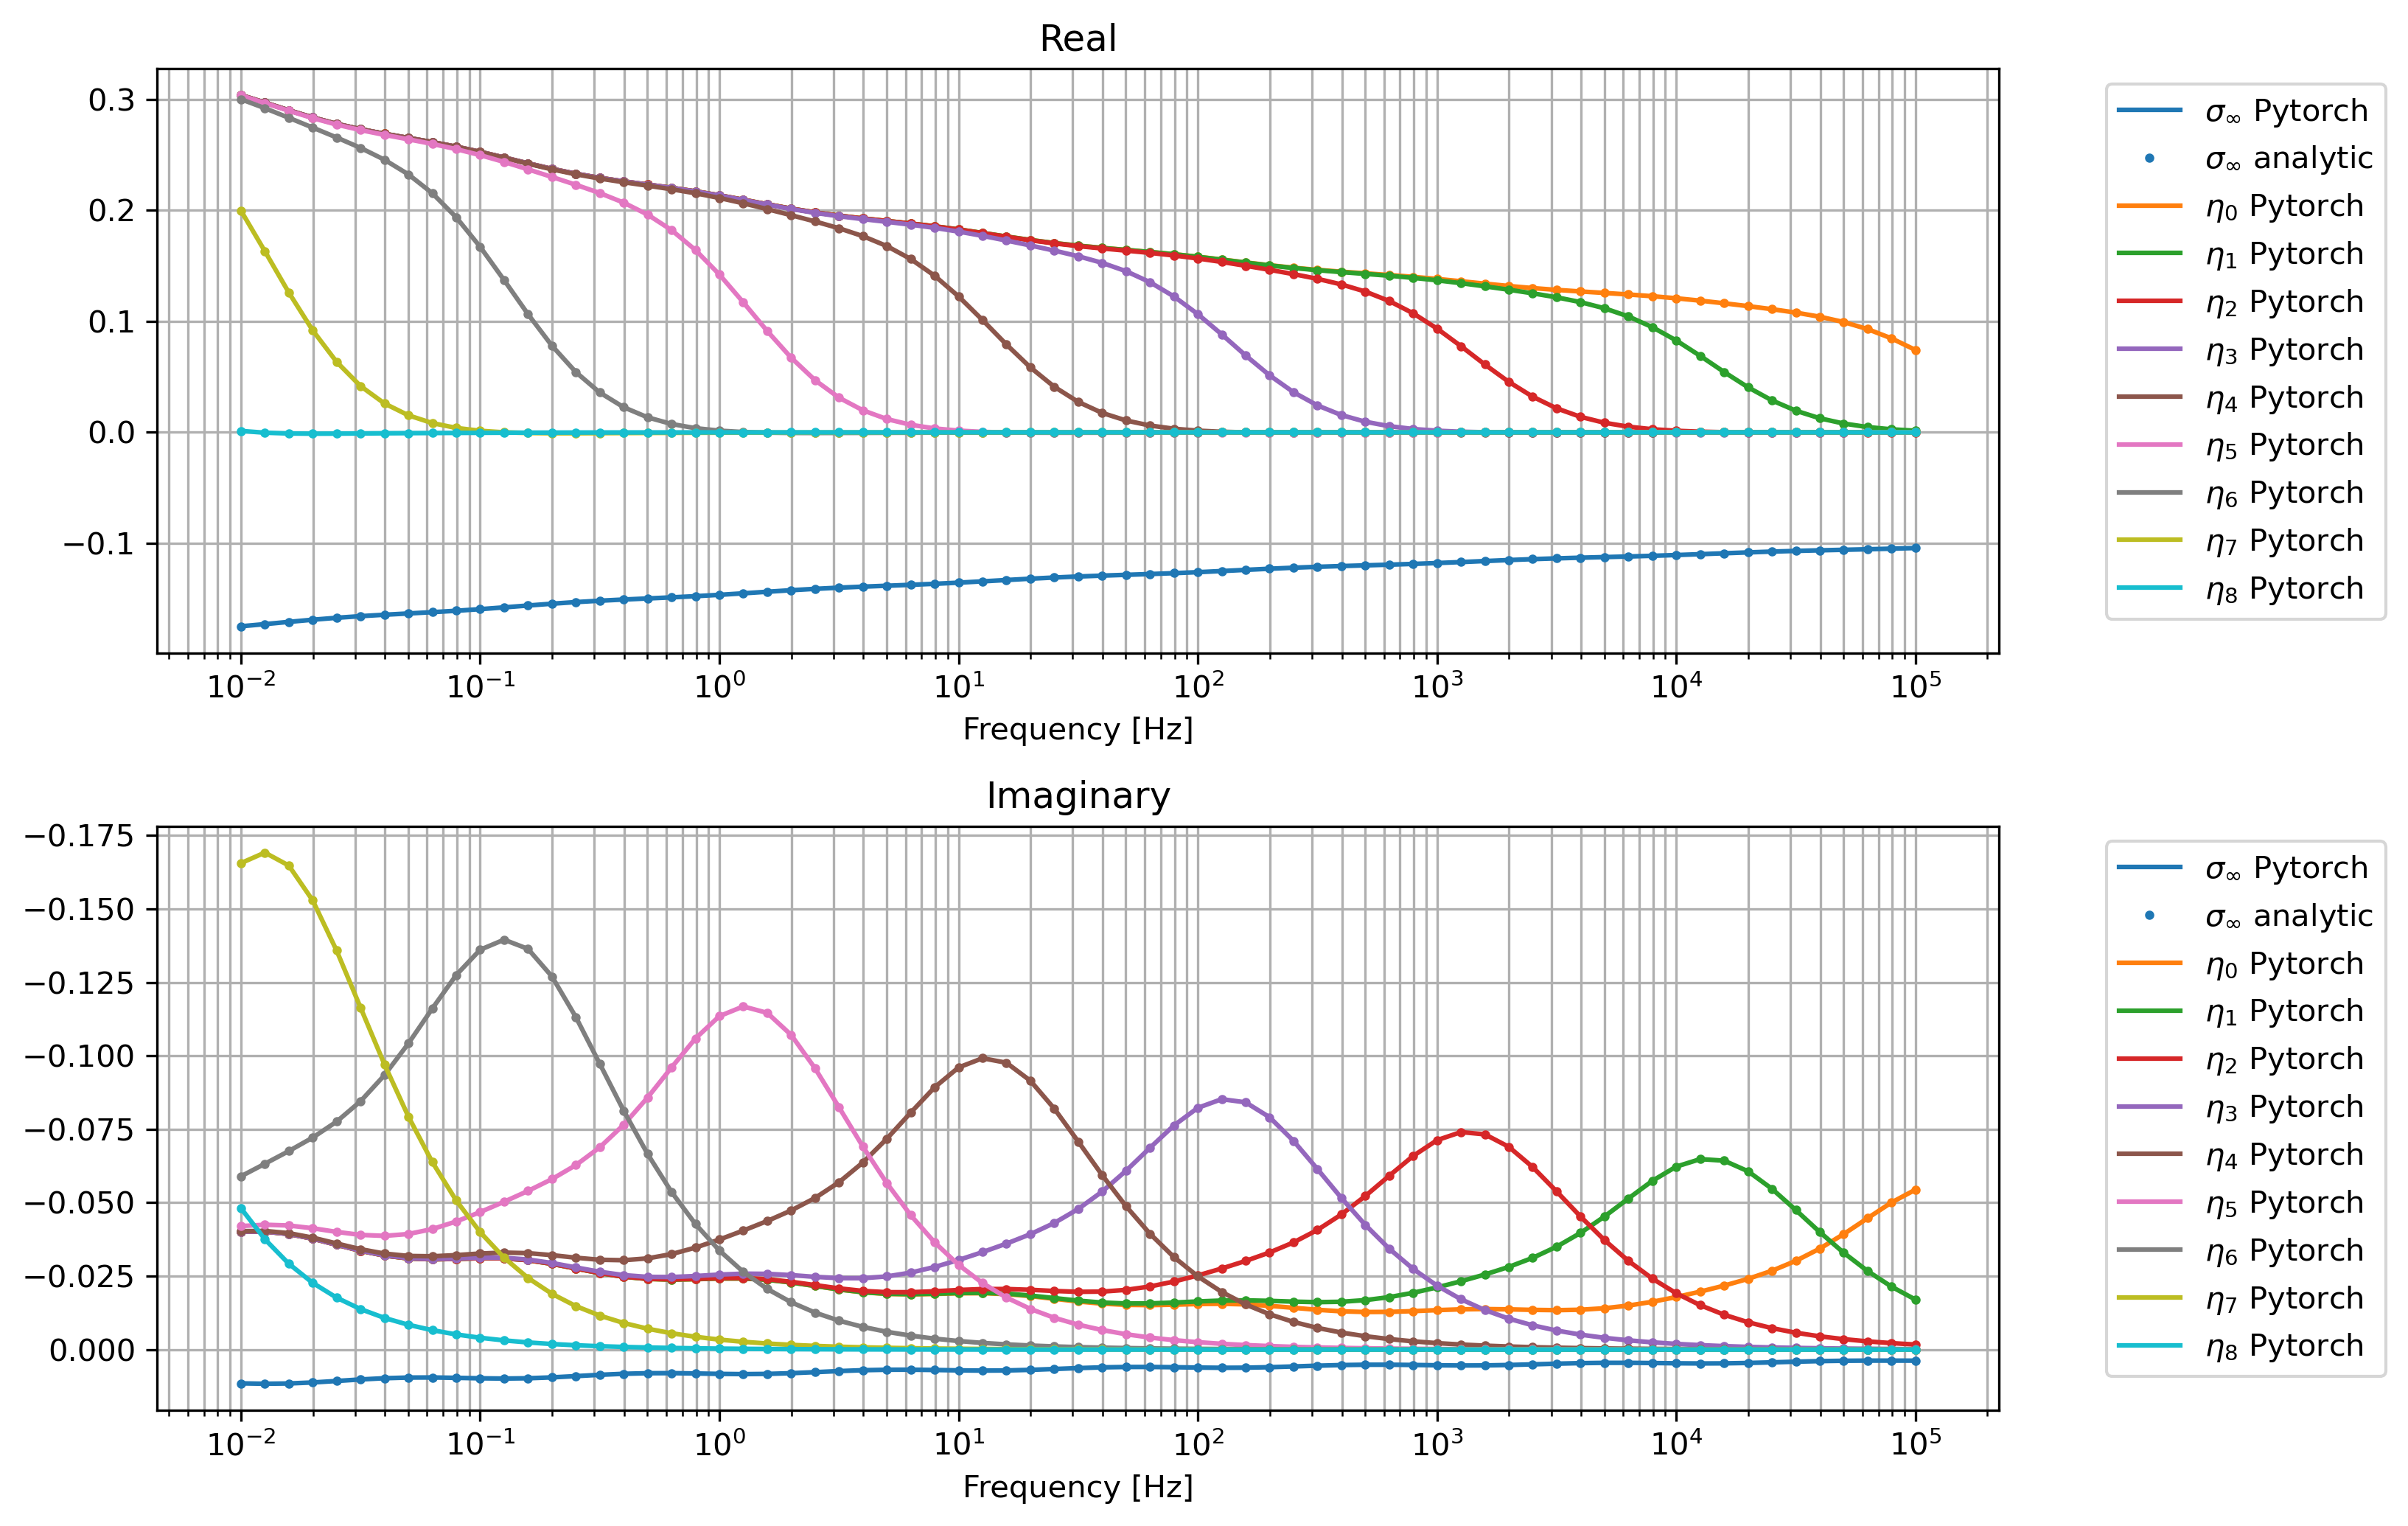

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(11, 7),dpi=300)

ax[0].semilogx(freq, J_torch_real[:,0], color="C0", 
               label=r"$\sigma_\infty$ Pytorch")
ax[0].semilogx(freq, J_np_real[:,0], color="C0",
            linestyle="",markersize=4.0, marker=".", label=r"$\sigma_\infty$ analytic")
ax[1].semilogx(freq, J_torch_imag[:,0], color="C0",
               label=r"$\sigma_\infty$ Pytorch")
ax[1].semilogx(freq, J_np_imag[:,0], color="C0",
            linestyle="",markersize=4.0, marker=".", label=r"$\sigma_\infty$ analytic")
for i in range(ntau):
    ax[0].semilogx(freq, J_torch_real[:,i+1], color=f"C{i+1}", 
                   label=f"$\eta_{i}$ Pytorch")
    ax[0].semilogx(freq, J_np_real[:,i+1], color=f"C{i+1}",
                         linestyle="",markersize=4.0, marker=".")
#     , label=f"$\eta_{i}$ analytic")
    ax[1].semilogx(freq, J_torch_imag[:,i+1], color=f"C{i+1}",
                     label=f"$\eta_{i}$ Pytorch")
    ax[1].semilogx(freq, J_np_imag[:,i+1], color=f"C{i+1}",
                         linestyle="",markersize=4.0, marker=".")
#     , 
#                          label=f"$\eta_{i}$ analytic")
ax[1].invert_yaxis()

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title('Real')
ax[1].set_title('Imaginary')
plt.tight_layout()
plt.savefig("30_AuoDiffValid_DDC_res_sip_J.jpg", dpi=300)